# Markov Decision Process

Considered Approaches:

- SAM2 for segmenting dice
- YOLOe for bounding boxes
- Mediapipe for hand tracking
- Cosmos-Reason2-8B as a ViT

## SAM2

!git clone https://github.com/facebookresearch/sam2.git
%cd sam2

In [1]:
#!pip install -e .
!pip install opencv-python matplotlib imageio imageio-ffmpeg
#!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121

In [2]:
import sys
print(sys.executable)

D:\miniconda3\envs\torch-gpu\python.exe


In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
video_path = "D:/ECEN524/Videos/data1.mov"

cap = cv2.VideoCapture(video_path)
frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

print("Total frames:", len(frames))

Total frames: 1707


In [5]:
from IPython.display import Video

Video(video_path)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
import sys, subprocess
import os

sam2_path = r"D:\ECEN524\sam2"
if sam2_path not in sys.path:
    sys.path.append(sam2_path)

In [8]:
#pip install hydra-core tqdm
#subprocess.check_call([sys.executable, "-m", "pip", "install", "decord"])
from sam2.build_sam import build_sam2_video_predictor
from sam2.sam2_video_predictor import SAM2VideoPredictor

In [9]:
os.environ["HYDRA_FULL_ERROR"] = "1"

import sam2
print("sam2 imported from:", sam2.__file__)
print("cwd:", __import__("os").getcwd())
print("top sys.path[0:5]:", sys.path[:5])

sam2 imported from: D:\ECEN524\sam2\sam2\__init__.py
cwd: D:\
top sys.path[0:5]: ['D:\\miniconda3\\envs\\torch-gpu\\python310.zip', 'D:\\miniconda3\\envs\\torch-gpu\\DLLs', 'D:\\miniconda3\\envs\\torch-gpu\\lib', 'D:\\miniconda3\\envs\\torch-gpu', '']


In [10]:
from sam2.modeling.backbones.hieradet import Hiera
print("Hiera import OK:", Hiera)

Hiera import OK: <class 'sam2.modeling.backbones.hieradet.Hiera'>


In [16]:
!ffmpeg -i "D:/ECEN524/Videos/data1.mov" -c:v libx264 -pix_fmt yuv420p output.mp4

ffmpeg version 7.1.1-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --enable-mediafound

In [22]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sam2.build_sam import build_sam2_video_predictor

# -------------------------------------------------
# 1️⃣ Paths (CHANGE THESE)
# -------------------------------------------------
video_path = "output.mp4"
config_file = "configs/sam2/sam2_hiera_t.yaml"      # 2.1 tiny
checkpoint_path = "checkpoints/sam2_hiera_tiny.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -------------------------------------------------
# 2️⃣ Build predictor
# -------------------------------------------------
predictor = build_sam2_video_predictor(
    config_file=config_file,
    checkpoint=checkpoint_path,
    device=device
)

# -------------------------------------------------
# 3️⃣ Initialize state (DO NOT load frames into memory)
# -------------------------------------------------
state = predictor.init_state(video_path)

# -------------------------------------------------
# 4️⃣ Read ONLY frame 0 to compute click location
# -------------------------------------------------
cap = cv2.VideoCapture(video_path)
ret, frame0_bgr = cap.read()
if not ret:
    cap.release()
    raise RuntimeError(f"Failed to read first frame from: {video_path}")

frame0 = cv2.cvtColor(frame0_bgr, cv2.COLOR_BGR2RGB)
h, w = frame0.shape[:2]
cap.release()

# -------------------------------------------------
# 5️⃣ Provide initial prompt on frame 0
# -------------------------------------------------
point = np.array([[w // 2, h // 2]], dtype=np.float32)  # (x, y)
label = np.array([1], dtype=np.int32)                  # 1 = positive click

predictor.add_new_points_or_box(
    inference_state=state,
    frame_idx=0,
    points=point,
    labels=label
)

# -------------------------------------------------
# 6️⃣ Propagate masks through video
# -------------------------------------------------
results = predictor.propagate_in_video(state)
print("Finished propagation")

# -------------------------------------------------
# 7️⃣ Visualize one frame result (read ONLY that frame)
# -------------------------------------------------
frame_idx = 10

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
ret, frame_bgr = cap.read()
cap.release()

if not ret:
    raise RuntimeError(f"Failed to read frame {frame_idx} from: {video_path}")

frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

# results indexing differs by repo version; handle both common formats
mask = None
r = results[frame_idx]

if isinstance(r, dict):
    # dict: {obj_id: mask}
    first_obj_id = next(iter(r.keys()))
    mask = r[first_obj_id]
elif isinstance(r, (list, tuple)):
    # list: [mask0, mask1, ...]
    mask = r[0]
else:
    raise TypeError(f"Unexpected results[frame_idx] type: {type(r)}")

plt.figure(figsize=(6, 6))
plt.imshow(frame)
plt.imshow(mask, alpha=0.5)
plt.title(f"Frame {frame_idx}")
plt.axis("off")
plt.show()

Using device: cuda


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5360320512 bytes.

## YOLOE

In [2]:
#pip install ultralytics

In [2]:
import cv2
import time
from ultralytics import YOLO

VIDEO_PATH = "Videos/data8.mov"
MODEL_PATH = "yolo11x-seg.pt"

# Load segmentation model (downloads first time)
model = YOLO(MODEL_PATH)
# Open video (.mov works if codecs installed)
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print("Error opening video file")
    exit()

# Target 60 FPS
frame_time = 1 / 60  

while True:
    start = time.time()

    ret, frame = cap.read()
    if not ret:
        break

    # Run segmentation on GPU
    results = model(frame, device=0, imgsz=640, verbose=False)

    annotated = results[0].plot()

    cv2.imshow("YOLO11 Segmentation 60FPS", annotated)

    # Maintain ~60 FPS
    elapsed = time.time() - start
    sleep_time = max(0, frame_time - elapsed)
    time.sleep(sleep_time)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [3]:
print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [4]:
import cv2
from ultralytics import YOLO

SPORTS_BALL_ID = 32  # confirm via model.names

model = YOLO(MODEL_PATH)
cap = cv2.VideoCapture(VIDEO_PATH)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.predict(
        frame,
        device=0,
        classes=[SPORTS_BALL_ID], # Exclusively for sports ball
        conf=0.10,
        iou=0.5,
        imgsz=960,      # bigger can help small balls (try 640/960/1280)
        verbose=False
    )

    cv2.imshow("Sports Ball Seg", results[0].plot())
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

In [122]:
import cv2
import os
from ultralytics import YOLO

# -------------------------------------------------
# Config
# -------------------------------------------------
VIDEO_DIR = "Videos"
VIDEO_LIST = ["data1.mov", "data2.mov", "data3.mov", "data6.mov", "data8.mov", "data9.mov"]

MODEL_PATH = "yolo11x-seg.pt"  # <-- set yours
DEVICE = 0
SPORTS_BALL_ID = 32  # confirm via model.names
CONF = 0.05
IOU = 0.3
IMGSZ = 1280

# -------------------------------------------------
# Load model once
# -------------------------------------------------
model = YOLO(MODEL_PATH)

def run_yolo_on_frame(frame_bgr):
    results = model.predict(
        frame_bgr,
        device=DEVICE,
        classes=[SPORTS_BALL_ID],
        conf=CONF,
        iou=IOU,
        imgsz=IMGSZ,
        verbose=False
    )
    # results[0].plot() returns an annotated BGR image
    return results[0].plot()

for video_name in VIDEO_LIST:
    video_path = os.path.join(VIDEO_DIR, video_name)
    print(f"\nLoading: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Could not open {video_path}")
        continue

    # -------------------------------
    # Read first frame
    # -------------------------------
    ret_first, first_frame = cap.read()
    if not ret_first:
        print("Could not read first frame.")
        cap.release()
        continue

    # -------------------------------
    # Read sequentially to get last frame (robust for .mov)
    # -------------------------------
    last_frame = first_frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        last_frame = frame

    cap.release()

    # -------------------------------
    # Run YOLO only on first + last
    # -------------------------------
    first_vis = run_yolo_on_frame(first_frame)
    last_vis  = run_yolo_on_frame(last_frame)

    # -------------------------------
    # Show results
    # -------------------------------
    
    cv2.imshow(f"{video_name} - FIRST (YOLO seg)", first_vis)
    cv2.imshow(f"{video_name} - LAST  (YOLO seg)", last_vis)

    print("Press any key for next video. Press 'q' to quit.")
    key = cv2.waitKey(0) & 0xFF
    cv2.destroyAllWindows()

    if key == ord("q"):
        break

cv2.destroyAllWindows()


Loading: Videos\data1.mov
Press any key for next video. Press 'q' to quit.

Loading: Videos\data2.mov
Press any key for next video. Press 'q' to quit.


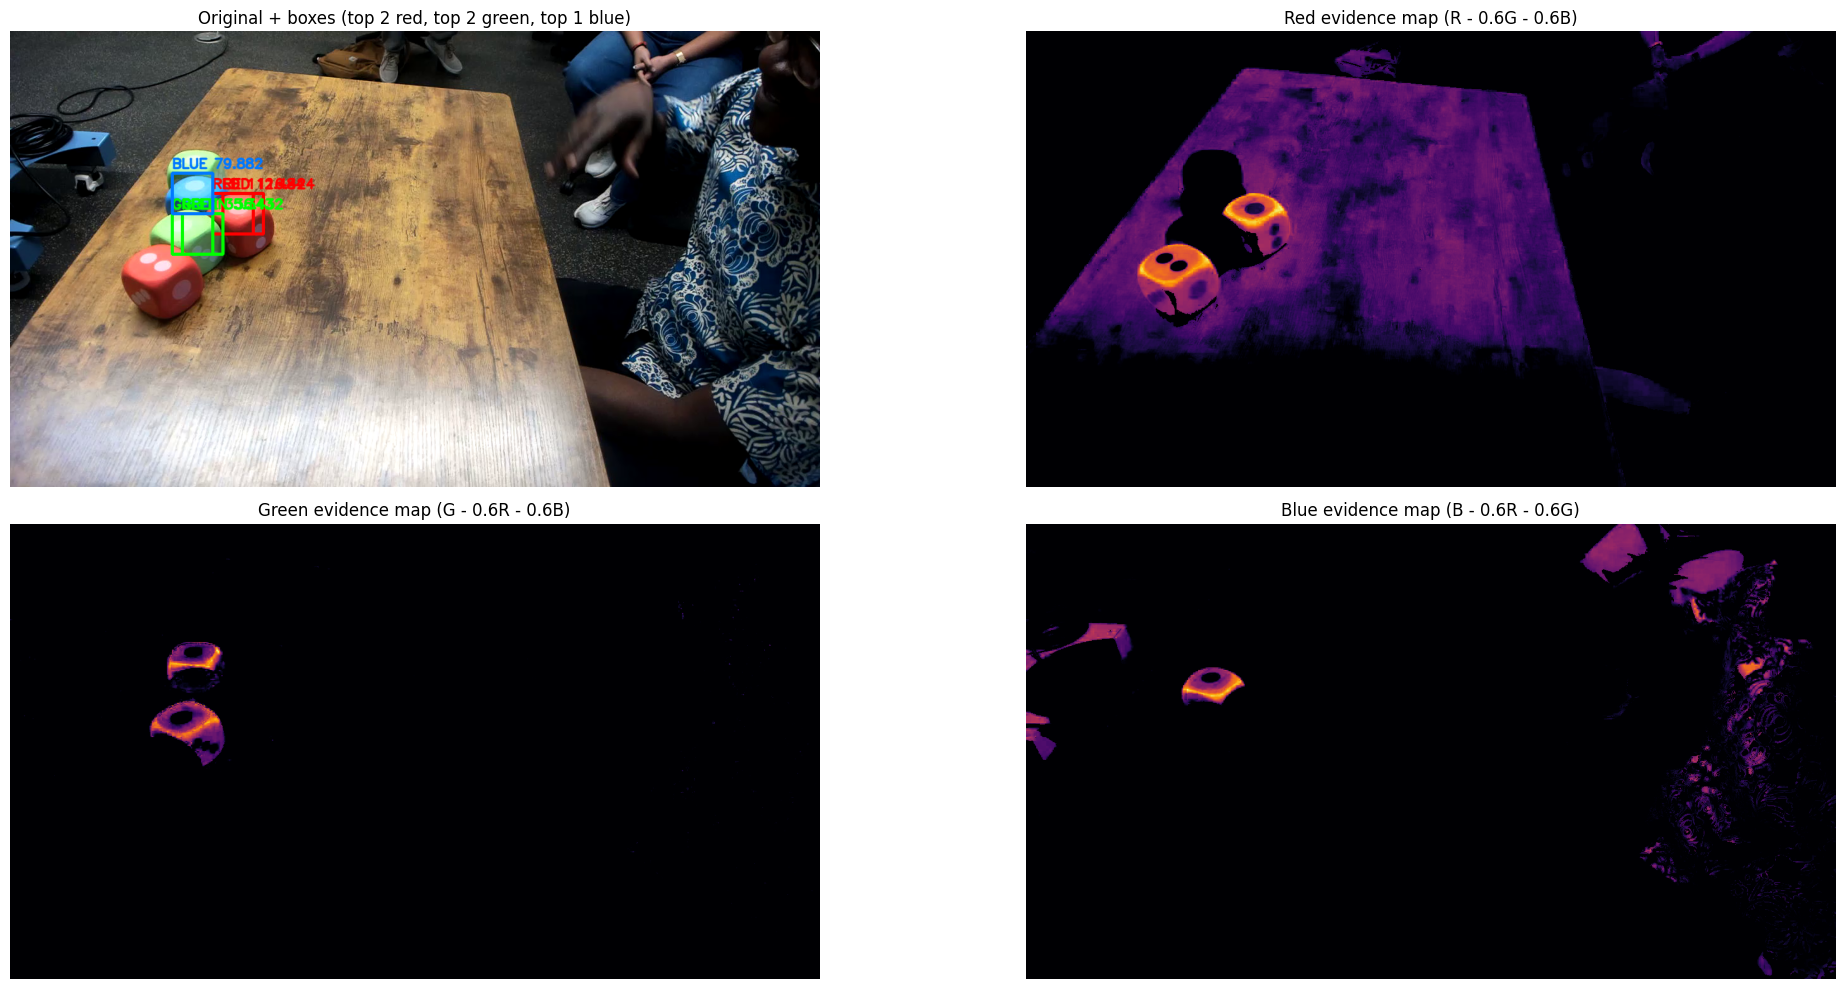

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Config (edit these)
# -------------------------
#IMG_PATH = "frame.jpg"      # <- change to your image path
PATCH = 64                  # region size (pixels). try 32, 64, 96
STRIDE = 16                 # scan stride. smaller = slower but finer
TOPK = 2                    # top K for red & green
TOPK_BLUE = 1               # top K for blue

# -------------------------
# Load image
# -------------------------
bgr = first_frame
if bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMG_PATH}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
R, G, B = rgb[..., 0], rgb[..., 1], rgb[..., 2]

# -------------------------
# Build "dense color" evidence maps
# (opponent-color scoring + ignore dark pixels)
# -------------------------
brightness = (R + G + B) / 3.0
mask = (brightness > 40).astype(np.float32)

red_score   = (R - 0.6*G - 0.6*B) * mask
green_score = (G - 0.6*R - 0.6*B) * mask
blue_score  = (B - 0.6*R - 0.6*G) * mask

red_score   = np.clip(red_score,   0, None)
green_score = np.clip(green_score, 0, None)
blue_score  = np.clip(blue_score,  0, None)

def norm01(x):
    mx = float(np.max(x))
    if mx < 1e-6:
        return x * 0.0
    return x / mx

red_map_vis   = norm01(red_score)
green_map_vis = norm01(green_score)
blue_map_vis  = norm01(blue_score)

# -------------------------
# Max-pool (dilation) + patch density (box filter)
# -------------------------
ks_pool = max(3, (PATCH // 8) | 1)  # odd
kernel = np.ones((ks_pool, ks_pool), np.uint8)

red_pooled   = cv2.dilate(red_score, kernel)
green_pooled = cv2.dilate(green_score, kernel)
blue_pooled  = cv2.dilate(blue_score, kernel)

red_density   = cv2.boxFilter(red_pooled,   ddepth=-1, ksize=(PATCH, PATCH), normalize=True)
green_density = cv2.boxFilter(green_pooled, ddepth=-1, ksize=(PATCH, PATCH), normalize=True)
blue_density  = cv2.boxFilter(blue_pooled,  ddepth=-1, ksize=(PATCH, PATCH), normalize=True)

# Grid sampling for argmax
H, W = red_density.shape
ys = np.arange(0, H - PATCH + 1, STRIDE)
xs = np.arange(0, W - PATCH + 1, STRIDE)

def build_grid(density):
    grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
    cy = PATCH // 2
    cx = PATCH // 2
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            grid[i, j] = density[y + cy, x + cx]
    return grid

grid_red = build_grid(red_density)
grid_grn = build_grid(green_density)
grid_blu = build_grid(blue_density)

def topk_boxes(grid, label, k):
    flat = grid.ravel()
    k = min(k, flat.size)
    idxs = np.argpartition(-flat, k-1)[:k]
    idxs = idxs[np.argsort(-flat[idxs])]  # sort descending
    out = []
    for idx in idxs:
        i = idx // grid.shape[1]
        j = idx %  grid.shape[1]
        y = int(ys[i])
        x = int(xs[j])
        out.append((x, y, float(grid[i, j]), label))
    return out

boxes = []
boxes += topk_boxes(grid_red, "RED", TOPK)
boxes += topk_boxes(grid_grn, "GREEN", TOPK)
boxes += topk_boxes(grid_blu, "BLUE", TOPK_BLUE)

# -------------------------
# Draw boxes
# -------------------------
draw = rgb.copy().astype(np.uint8)
color_map = {
    "RED":   (255, 0, 0),
    "GREEN": (0, 255, 0),
    "BLUE":  (0, 120, 255)  # a visible blue in RGB display
}

for (x, y, s, name) in boxes:
    c = color_map[name]
    cv2.rectangle(draw, (x, y), (x + PATCH, y + PATCH), c, 3)
    cv2.putText(draw, f"{name} {s:.3f}", (x, max(0, y - 8)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, c, 2, cv2.LINE_AA)

# -------------------------
# Show results
# -------------------------
plt.figure(figsize=(22, 10))

plt.subplot(2, 2, 1)
plt.title(f"Original + boxes (top {TOPK} red, top {TOPK} green, top {TOPK_BLUE} blue)")
plt.imshow(draw)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Red evidence map (R - 0.6G - 0.6B)")
plt.imshow(red_map_vis, cmap="inferno")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Green evidence map (G - 0.6R - 0.6B)")
plt.imshow(green_map_vis, cmap="inferno")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Blue evidence map (B - 0.6R - 0.6G)")
plt.imshow(blue_map_vis, cmap="inferno")
plt.axis("off")

plt.tight_layout()
plt.show()

### Identify the colors

We use the segmentations to determine the color of every detected dice. <br>
Next, we find the rightmost value in the first 70 frames and overlay over the video to define the threshold.


In [53]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO

# --- Config ---
MODEL_PATH = "yolo11x-seg.pt"
VIDEO_PATH = "Videos/data2.mov"
CONF = 0.05           # lower = more likely to find it (more false positives)
IOU = 0.3
IMGSZ = 960          # try 640/960/1280 for small balls
DEVICE = 0            # 0 = GPU, or "cpu"

# COCO class id for "sports ball" is usually 32 (confirm with print(model.names))
SPORTS_BALL_ID = 32

def dominant_rgb_name(rgb_mean: np.ndarray) -> str:
    idx = int(np.argmax(rgb_mean))
    return ["red", "green", "blue"][idx]

model = YOLO(MODEL_PATH)
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS) or 0.0

rows = []  # <- collect detections here
frame_idx = 0

while True:
    ret, frame_bgr = cap.read()
    if not ret:
        break

    # Predict ONLY sports ball
    results = model.predict(
        frame_bgr,
        device=DEVICE,
        classes=[SPORTS_BALL_ID],
        conf=CONF,
        iou=IOU,
        imgsz=IMGSZ,
        verbose=False
    )

    r = results[0]
    annotated = frame_bgr.copy()

    # If nothing detected, just show frame
    if r.boxes is None or len(r.boxes) == 0:
        cv2.imshow("Sports ball + color", annotated)
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        frame_idx += 1
        continue

    masks = None
    if r.masks is not None and r.masks.data is not None:
        masks = r.masks.data  # torch tensor: (N, H, W)

    boxes = r.boxes.xyxy.cpu().numpy().astype(int)  # (N,4)
    confs = r.boxes.conf.cpu().numpy()              # (N,)

    annotated = r.plot()

    h, w = frame_bgr.shape[:2]
    timestamp_s = (frame_idx / fps) if fps > 0 else None

    for i, (x1, y1, x2, y2) in enumerate(boxes):
        label_color = "unknown"

        if masks is not None and i < masks.shape[0]:
            mask_i = masks[i].detach().cpu().numpy()
            mask_i = (mask_i > 0.5).astype(np.uint8)

            if mask_i.shape != (h, w):
                mask_i = cv2.resize(mask_i, (w, h), interpolation=cv2.INTER_NEAREST)

            ys, xs = np.where(mask_i == 1)
            if len(xs) > 0:
                pixels_bgr = frame_bgr[ys, xs]
                mean_bgr = pixels_bgr.mean(axis=0)   # [B,G,R]
                mean_rgb = mean_bgr[::-1]            # [R,G,B]
                label_color = dominant_rgb_name(mean_rgb)

        # --- Save to dataframe rows ---
        cx = (x1 + x2) / 2.0
        cy = (y1 + y2) / 2.0
        rows.append({
            "frame_idx": frame_idx,
            "timestamp_s": timestamp_s,
            "det_idx": i,
            "x1": int(x1), "y1": int(y1), "x2": int(x2), "y2": int(y2),
            "cx": float(cx), "cy": float(cy),
            "conf": float(confs[i]),
            "color": label_color,
        })

        # --- Draw label ---
        text = f"sports ball - {label_color} ({confs[i]:.2f})"
        cv2.putText(
            annotated, text,
            (x1, max(0, y1 - 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6, (255, 255, 255), 2, cv2.LINE_AA
        )

    cv2.imshow("Sports ball + color", annotated)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    frame_idx += 1

cap.release()
cv2.destroyAllWindows()

df = pd.DataFrame(rows)
print(df.head())
print(f"Saved {len(df)} detections")
# df.to_csv("sports_ball_detections.csv", index=False)

   frame_idx  timestamp_s  det_idx   x1   y1   x2   y2     cx     cy  \
0          0          0.0        0  236  217  341  314  288.5  265.5   
1          0          0.0        1  224  161  304  242  264.0  201.5   
2          0          0.0        2  297  139  387  195  342.0  167.0   
3          0          0.0        3  301  178  396  269  348.5  223.5   
4          0          0.0        4  343  217  430  312  386.5  264.5   

       conf  color  
0  0.909545    red  
1  0.746691    red  
2  0.730164   blue  
3  0.451618  green  
4  0.224137  green  
Saved 1765 detections


In [54]:
df.to_csv(f"{VIDEO_PATH}.csv", index=False)
print("Saved dataframe to data.csv")

Saved dataframe to data.csv


In [55]:
import pandas as pd
# max_x2_value = df[df["frame_idx"] < 70]["x2"].max()
df = pd.read_csv("Videos/data2.mov.csv")

video_path = "Videos/data2.mov"  # or set: "path/to/video.mp4"
# ----------------------------
# 1️⃣ Filter first 70 frames
# ----------------------------
df_first70 = df[df["frame_idx"] < 70]


if df_first70.empty:
    raise ValueError("No detections found in first 70 frames.")

# ----------------------------
# 2️⃣ Find maximum x2 value
# ----------------------------
max_x2_value = df_first70["x2"].max()

# ----------------------------
# 3️⃣ Get the row(s) where this occurs
# ----------------------------
max_x2_rows = df_first70[df_first70["x2"] == max_x2_value]

print("Greatest x2 value in first 70 frames:", max_x2_value)
print("\nRow(s) where this occurs:")
print(max_x2_rows)

# Assumes you already computed this:
# max_x2_value = df[df["frame_idx"] < 70]["x2"].max()

x_line = int(max_x2_value) + 40

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {video_path}")

w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Clamp line to frame bounds just in case
x_line = max(0, min(x_line, w - 1))

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Draw vertical line at x = max_x2_value
    cv2.line(frame, (x_line, 0), (x_line, h - 1), (0, 255, 255), 2)
    cv2.putText(
        frame,
        f"x = {x_line}",
        (x_line + 10 if x_line < w - 120 else max(0, x_line - 120), 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 255),
        2,
        cv2.LINE_AA,
    )

    cv2.imshow("Playback with x=max_x2 overlay", frame)

    # Controls:
    # - 'q' quits
    # - 'p' pauses/unpauses
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break
    elif key == ord("p"):
        # pause loop until 'p' pressed again (or 'q' to quit)
        while True:
            k2 = cv2.waitKey(0) & 0xFF
            if k2 == ord("p"):
                break
            if k2 == ord("q"):
                cap.release()
                cv2.destroyAllWindows()
                raise SystemExit

    frame_idx += 1

cap.release()
cv2.destroyAllWindows()

Greatest x2 value in first 70 frames: 509

Row(s) where this occurs:
     frame_idx  timestamp_s  det_idx   x1   y1   x2   y2     cx     cy  \
328         69     1.197831        4  392  117  509  231  450.5  174.0   

         conf  color  
328  0.494134  green  


Next we will want to record the positions of each dice. With this, we can determine a confidence for which dice has been moved

If we have time we should try optical flow

Remember part of the assignment is to determine when each one is held and actively moved, we will have to pair this data with mediapipe/hand tracking

## Mediapipe

In [5]:
#pip install mediapipe

  Using cached absl_py-2.4.0-py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   -------------------------- ------------- 6.8/10.2 MB 69.7 MB/s eta 0:00:01
   ---------------------------------------- 10.2/10.2 MB 35.4 MB/s  0:00:00
Using cached absl_py-2.4.0-py3-none-any.whl (135 kB)
   ---------------------------------------- 0.0/46.5 MB ? eta -:--:--
   --------------- ------------------------ 17.6/46.5 MB 79.0 MB/s eta 0:00:01
   ----------------------------- ---------- 33.8/46.5 MB 82.6 MB/s eta 0:00:01
   -------------------------------------- - 44.3/46.5 MB 72.3 MB/s eta 0:00:01
   ---------------------------------------  46.4/46.5 MB 70.3 MB/s eta 0:00:01
   ---------------------------------------  46.4/46.5 MB 70.3 MB/s eta 0:00:01
   ---------------------------------------- 46.5/46.5 MB 40.5 MB/s  0:00:01

   -------- ------------------------------- 1/5 [opencv-contrib-python]

Note: you may need to restart the kernel to 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'D:\\miniconda3\\envs\\torch-gpu\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [2]:
import mediapipe as mp
import sys, os

print("python:", sys.executable)
print("mediapipe module file:", getattr(mp, "__file__", None))
print("mediapipe version:", getattr(mp, "__version__", None))
print("cwd:", os.getcwd())
print("has solutions?:", hasattr(mp, "solutions"))
print("top-level attrs sample:", [a for a in dir(mp) if a in ("solutions", "tasks", "python")])

python: D:\miniconda3\envs\torch-gpu\python.exe
mediapipe module file: D:\miniconda3\envs\torch-gpu\lib\site-packages\mediapipe\__init__.py
mediapipe version: 0.10.32
cwd: D:\ECEN524
has solutions?: False
top-level attrs sample: ['tasks']


In [120]:
import os
import urllib.request
import cv2
import mediapipe as mp

from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# -----------------------------
# 1) Paths
# -----------------------------
VIDEO_PATH = "Videos/data1.mov"
MODEL_PATH = "hand_landmarker.task"      # downloaded if missing

# Official model URL (Hand Landmarker)
MODEL_URL = "https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/latest/hand_landmarker.task"

# -----------------------------
# 2) Download model if needed
# -----------------------------
if not os.path.exists(MODEL_PATH):
    print("Downloading hand landmarker model...")
    urllib.request.urlretrieve(MODEL_URL, MODEL_PATH)
    print("Saved:", MODEL_PATH)

# -----------------------------
# 3) Hand connections (21 landmarks)
# -----------------------------
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),        # thumb
    (0,5),(5,6),(6,7),(7,8),        # index
    (0,9),(9,10),(10,11),(11,12),   # middle
    (0,13),(13,14),(14,15),(15,16), # ring
    (0,17),(17,18),(18,19),(19,20), # pinky
    (5,9),(9,13),(13,17)            # palm
]

def draw_hand(frame_bgr, hand_landmarks):
    h, w = frame_bgr.shape[:2]
    pts = [(int(lm.x * w), int(lm.y * h)) for lm in hand_landmarks]

    # draw connections
    for a, b in HAND_CONNECTIONS:
        cv2.line(frame_bgr, pts[a], pts[b], (255, 0, 0), 2)

    # draw keypoints
    for (x, y) in pts:
        cv2.circle(frame_bgr, (x, y), 3, (0, 255, 0), -1)

    return frame_bgr

# -----------------------------
# 4) Create HandLandmarker (VIDEO mode)
# -----------------------------
BaseOptions = python.BaseOptions
HandLandmarker = vision.HandLandmarker
HandLandmarkerOptions = vision.HandLandmarkerOptions
VisionRunningMode = vision.RunningMode

options = HandLandmarkerOptions(
    base_options=BaseOptions(model_asset_path=MODEL_PATH),
    running_mode=VisionRunningMode.VIDEO,
    num_hands=2,
    min_hand_detection_confidence=0.5,
    min_hand_presence_confidence=0.5,
    min_tracking_confidence=0.5,
)

# -----------------------------
# 5) Open video
# -----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
fps = fps if fps and fps > 0 else 30.0
wait_ms = max(1, int(1000 / fps))

print(f"Opened {VIDEO_PATH} @ {fps:.2f} fps")
print("Controls: press 'q' to quit, space to pause/resume")

paused = False
frame_idx = 0

with HandLandmarker.create_from_options(options) as landmarker:
    while True:
        if not paused:
            ok, frame_bgr = cap.read()
            if not ok:
                break

            # timestamp in ms for VIDEO mode
            timestamp_ms = int((frame_idx / fps) * 1000)
            frame_idx += 1

            # BGR -> RGB for MediaPipe
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
            result = landmarker.detect_for_video(mp_image, timestamp_ms)

            # overlay
            if result.hand_landmarks:
                for hand_lms in result.hand_landmarks:
                    draw_hand(frame_bgr, hand_lms)

            cv2.imshow("MediaPipe Hands (Tasks API)", frame_bgr)

        key = cv2.waitKey(wait_ms if not paused else 30) & 0xFF
        if key == ord('q'):
            break
        elif key == 32:  # spacebar
            paused = not paused

cap.release()
cv2.destroyAllWindows()
print("Done.")

Opened Videos/data1.mov @ 60.11 fps
Controls: press 'q' to quit, space to pause/resume
Done.


Does not work for dark skin tones!

## Homemade Vision Model

Finding the highest density region of r,g, and b to detect one dice, and then masking out the neighborhood to find the next

### Color Detection Breakdown

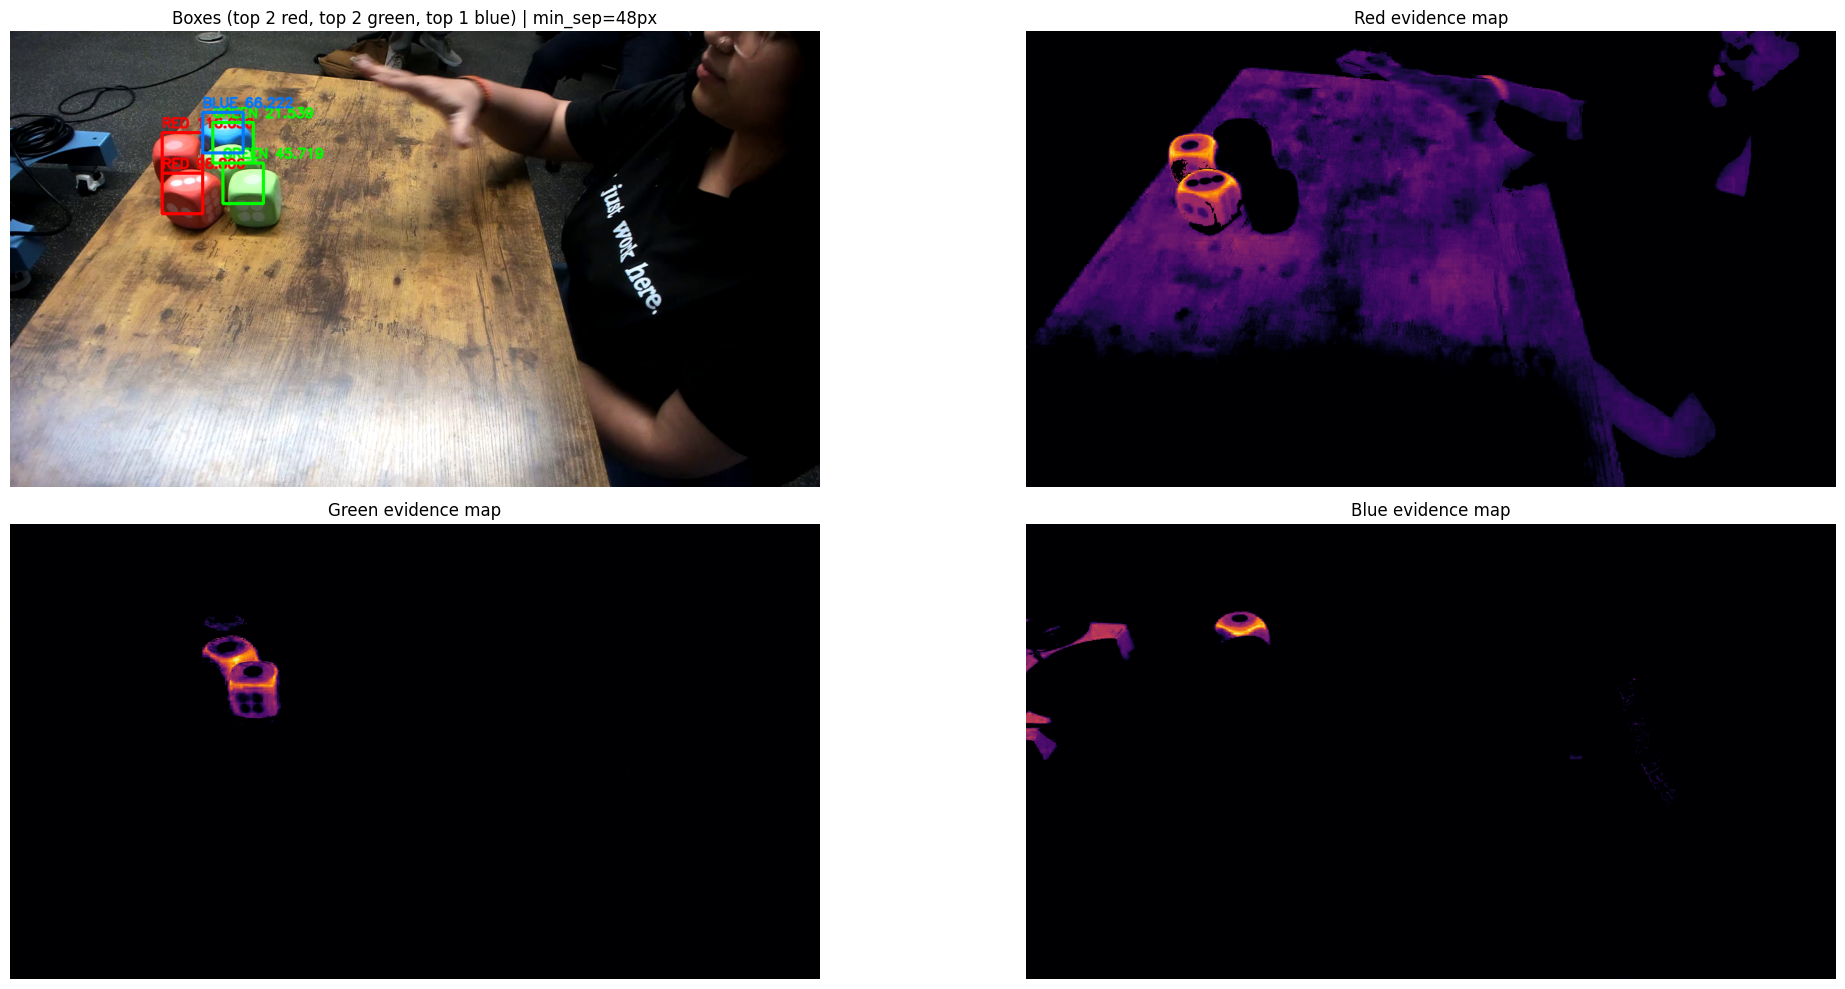

In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Config (edit these)
# -------------------------
PATCH = 64
STRIDE = 16
TOPK = 2
TOPK_BLUE = 1

# Minimum separation between selected centers (in pixels)
# Good default: ~0.75*PATCH to avoid picking same object twice
MIN_SEP_PX = int(0.75 * PATCH)

# -------------------------
# Load image
# -------------------------
bgr = first_frame
if bgr is None:
    raise FileNotFoundError(f"Could not read image: {IMG_PATH}")

rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
R, G, B = rgb[..., 0], rgb[..., 1], rgb[..., 2]

# -------------------------
# Evidence maps (opponent-color)
# -------------------------
brightness = (R + G + B) / 3.0
mask = (brightness > 40).astype(np.float32)

red_score   = np.clip((R - 0.6*G - 0.6*B) * mask, 0, None)
green_score = np.clip((G - 0.6*R - 0.6*B) * mask, 0, None)
blue_score  = np.clip((B - 0.6*R - 0.6*G) * mask, 0, None)

def norm01(x):
    mx = float(np.max(x))
    return (x / mx) if mx > 1e-6 else x * 0.0

red_map_vis   = norm01(red_score)
green_map_vis = norm01(green_score)
blue_map_vis  = norm01(blue_score)

# -------------------------
# Max-pool (dilation) + patch density (box filter)
# -------------------------
ks_pool = max(3, (PATCH // 8) | 1)
kernel = np.ones((ks_pool, ks_pool), np.uint8)

red_pooled   = cv2.dilate(red_score, kernel)
green_pooled = cv2.dilate(green_score, kernel)
blue_pooled  = cv2.dilate(blue_score, kernel)

red_density   = cv2.boxFilter(red_pooled,   ddepth=-1, ksize=(PATCH, PATCH), normalize=True)
green_density = cv2.boxFilter(green_pooled, ddepth=-1, ksize=(PATCH, PATCH), normalize=True)
blue_density  = cv2.boxFilter(blue_pooled,  ddepth=-1, ksize=(PATCH, PATCH), normalize=True)

H, W = red_density.shape
ys = np.arange(0, H - PATCH + 1, STRIDE)
xs = np.arange(0, W - PATCH + 1, STRIDE)

def build_grid(density):
    grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
    cy = PATCH // 2
    cx = PATCH // 2
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            grid[i, j] = density[y + cy, x + cx]
    return grid

grid_red = build_grid(red_density)
grid_grn = build_grid(green_density)
grid_blu = build_grid(blue_density)

# -------------------------
# Spatially-separated top-K selection
# Greedy: pick best, then suppress a radius around it (in grid coords)
# -------------------------
def topk_separated(grid, label, k, min_sep_px):
    grid_work = grid.copy()
    picks = []

    # Convert pixel separation to grid-cell separation (ceil)
    min_sep_cells = int(np.ceil(min_sep_px / float(STRIDE)))
    if min_sep_cells < 1:
        min_sep_cells = 1

    for _ in range(k):
        # If everything is ~0, stop
        max_val = float(grid_work.max())
        if max_val <= 1e-9:
            break

        idx = int(np.argmax(grid_work))
        i = idx // grid_work.shape[1]
        j = idx %  grid_work.shape[1]

        y = int(ys[i])
        x = int(xs[j])
        score = float(grid_work[i, j])
        picks.append((x, y, score, label))

        # Suppress neighborhood so next pick isn't nearby
        i0 = max(0, i - min_sep_cells)
        i1 = min(grid_work.shape[0], i + min_sep_cells + 1)
        j0 = max(0, j - min_sep_cells)
        j1 = min(grid_work.shape[1], j + min_sep_cells + 1)
        grid_work[i0:i1, j0:j1] = 0.0

    return picks

boxes = []
boxes += topk_separated(grid_red, "RED", TOPK, MIN_SEP_PX)
boxes += topk_separated(grid_grn, "GREEN", TOPK, MIN_SEP_PX)
boxes += topk_separated(grid_blu, "BLUE", TOPK_BLUE, MIN_SEP_PX)

# -------------------------
# Draw boxes
# -------------------------
draw = rgb.copy().astype(np.uint8)
color_map = {
    "RED":   (255, 0, 0),
    "GREEN": (0, 255, 0),
    "BLUE":  (0, 120, 255),
}

for (x, y, s, name) in boxes:
    c = color_map[name]
    cv2.rectangle(draw, (x, y), (x + PATCH, y + PATCH), c, 3)
    cv2.putText(draw, f"{name} {s:.3f}", (x, max(0, y - 8)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, c, 2, cv2.LINE_AA)

# -------------------------
# Show results
# -------------------------
plt.figure(figsize=(22, 10))

plt.subplot(2, 2, 1)
plt.title(f"Boxes (top {TOPK} red, top {TOPK} green, top {TOPK_BLUE} blue) | min_sep={MIN_SEP_PX}px")
plt.imshow(draw)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Red evidence map")
cv2.imwrite("proj2_figs/RedEvidence.jpg", red_map_vis)
plt.imshow(red_map_vis, cmap="inferno")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("Green evidence map")
cv2.imwrite("proj2_figs/GreenEvidence.jpg", green_map_vis)
plt.imshow(green_map_vis, cmap="inferno")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("Blue evidence map")
cv2.imwrite("proj2_figs/BlueEvidence.jpg", blue_map_vis)
plt.imshow(blue_map_vis, cmap="inferno")
plt.axis("off")

plt.tight_layout()
plt.savefig("proj2_figs/ColorBreakdown.pdf")
plt.show()

### Applying this frame by frame in a video

In [1]:
import cv2
import numpy as np

# -------------------------
# Config (edit these)
# -------------------------
VIDEO_PATH = "Videos/data8.mov"
PATCH = 64
STRIDE = 16
TOPK = 2
TOPK_BLUE = 1
MIN_SEP_PX = int(0.75 * PATCH)

# Evidence tuning
DARK_THRESH = 40
OPP_W = 0.6

# Playback
FPS_OVERRIDE = None        # set to e.g. 60 to force playback speed, or None to use video FPS
WINDOW_NAME = "Color-density boxes (R/G/B)"

# -------------------------
# Helpers
# -------------------------
def build_evidence_maps(rgb_f32):
    R, G, B = rgb_f32[..., 0], rgb_f32[..., 1], rgb_f32[..., 2]
    brightness = (R + G + B) / 3.0
    mask = (brightness > DARK_THRESH).astype(np.float32)

    red_score   = np.clip((R - OPP_W*G - OPP_W*B) * mask, 0, None)
    green_score = np.clip((G - OPP_W*R - OPP_W*B) * mask, 0, None)
    blue_score  = np.clip((B - OPP_W*R - OPP_W*G) * mask, 0, None)
    return red_score, green_score, blue_score

def density_from_score(score, patch, ks_pool):
    kernel = np.ones((ks_pool, ks_pool), np.uint8)
    pooled = cv2.dilate(score, kernel)  # max-pool-ish
    density = cv2.boxFilter(pooled, ddepth=-1, ksize=(patch, patch), normalize=True)
    return density

def topk_separated_from_density(density, label, k, patch, stride, min_sep_px):
    H, W = density.shape
    if H < patch or W < patch:
        return []

    ys = np.arange(0, H - patch + 1, stride)
    xs = np.arange(0, W - patch + 1, stride)

    # grid of density sampled at patch centers
    cy, cx = patch // 2, patch // 2
    grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            grid[i, j] = density[y + cy, x + cx]

    grid_work = grid.copy()
    picks = []

    min_sep_cells = int(np.ceil(min_sep_px / float(stride)))
    min_sep_cells = max(1, min_sep_cells)

    for _ in range(min(k, grid_work.size)):
        max_val = float(grid_work.max())
        if max_val <= 1e-9:
            break

        idx = int(np.argmax(grid_work))
        i = idx // grid_work.shape[1]
        j = idx %  grid_work.shape[1]

        y = int(ys[i])
        x = int(xs[j])
        score = float(grid_work[i, j])
        picks.append((x, y, score, label))

        i0 = max(0, i - min_sep_cells)
        i1 = min(grid_work.shape[0], i + min_sep_cells + 1)
        j0 = max(0, j - min_sep_cells)
        j1 = min(grid_work.shape[1], j + min_sep_cells + 1)
        grid_work[i0:i1, j0:j1] = 0.0

    return picks

def process_frame_bgr(frame_bgr):
    # BGR -> RGB float32
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

    red_score, green_score, blue_score = build_evidence_maps(rgb)

    ks_pool = max(3, (PATCH // 8) | 1)  # odd
    red_density   = density_from_score(red_score,   PATCH, ks_pool)
    green_density = density_from_score(green_score, PATCH, ks_pool)
    blue_density  = density_from_score(blue_score,  PATCH, ks_pool)

    boxes = []
    boxes += topk_separated_from_density(red_density,   "RED",   TOPK,      PATCH, STRIDE, MIN_SEP_PX)
    boxes += topk_separated_from_density(green_density, "GREEN", TOPK,      PATCH, STRIDE, MIN_SEP_PX)
    boxes += topk_separated_from_density(blue_density,  "BLUE",  TOPK_BLUE, PATCH, STRIDE, MIN_SEP_PX)

    # Draw on a copy (BGR for cv2.imshow)
    out = frame_bgr.copy()

    # BGR colors for OpenCV drawing
    draw_color = {
        "RED":   (0, 0, 255),
        "GREEN": (0, 255, 0),
        "BLUE":  (255, 80, 0),
    }

    for (x, y, s, name) in boxes:
        c = draw_color[name]
        cv2.rectangle(out, (x, y), (x + PATCH, y + PATCH), c, 3)
        cv2.putText(out, f"{name} {s:.3f}", (x, max(20, y - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, c, 2, cv2.LINE_AA)

    return out

# -------------------------
# Video loop
# -------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps <= 1e-6:
    fps = 30.0
if FPS_OVERRIDE is not None:
    fps = float(FPS_OVERRIDE)

delay_ms = max(1, int(round(1000.0 / fps)))

print(f"Playing: {VIDEO_PATH}")
print(f"FPS used: {fps:.2f}  | delay: {delay_ms} ms  | PATCH={PATCH}, STRIDE={STRIDE}, MIN_SEP_PX={MIN_SEP_PX}")
print("Controls: q=quit, space=pause/resume, <= rewind 1s, => forward 1s")

paused = False

while True:
    if not paused:
        ret, frame = cap.read()
        if not ret:
            break
        vis = process_frame_bgr(frame)
        cv2.imshow(WINDOW_NAME, vis)

    key = cv2.waitKey(0 if paused else delay_ms) & 0xFF

    # Quit
    if key == ord('q'):
        break

    # Pause toggle
    if key == ord(' '):
        paused = not paused
        continue

    # Seek backward/forward ~1s (works best on mp4; some movs may be less precise)
    if key == 81:  # left arrow
        t = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, max(0.0, t - 1000.0))
        paused = False
    elif key == 83:  # right arrow
        t = cap.get(cv2.CAP_PROP_POS_MSEC)
        cap.set(cv2.CAP_PROP_POS_MSEC, t + 1000.0)
        paused = False

cap.release()
cv2.destroyAllWindows()

Playing: Videos/data8.mov
FPS used: 59.92  | delay: 17 ms  | PATCH=64, STRIDE=16, MIN_SEP_PX=48
Controls: q=quit, space=pause/resume, <= rewind 1s, => forward 1s


### Masking for the Region of Interest

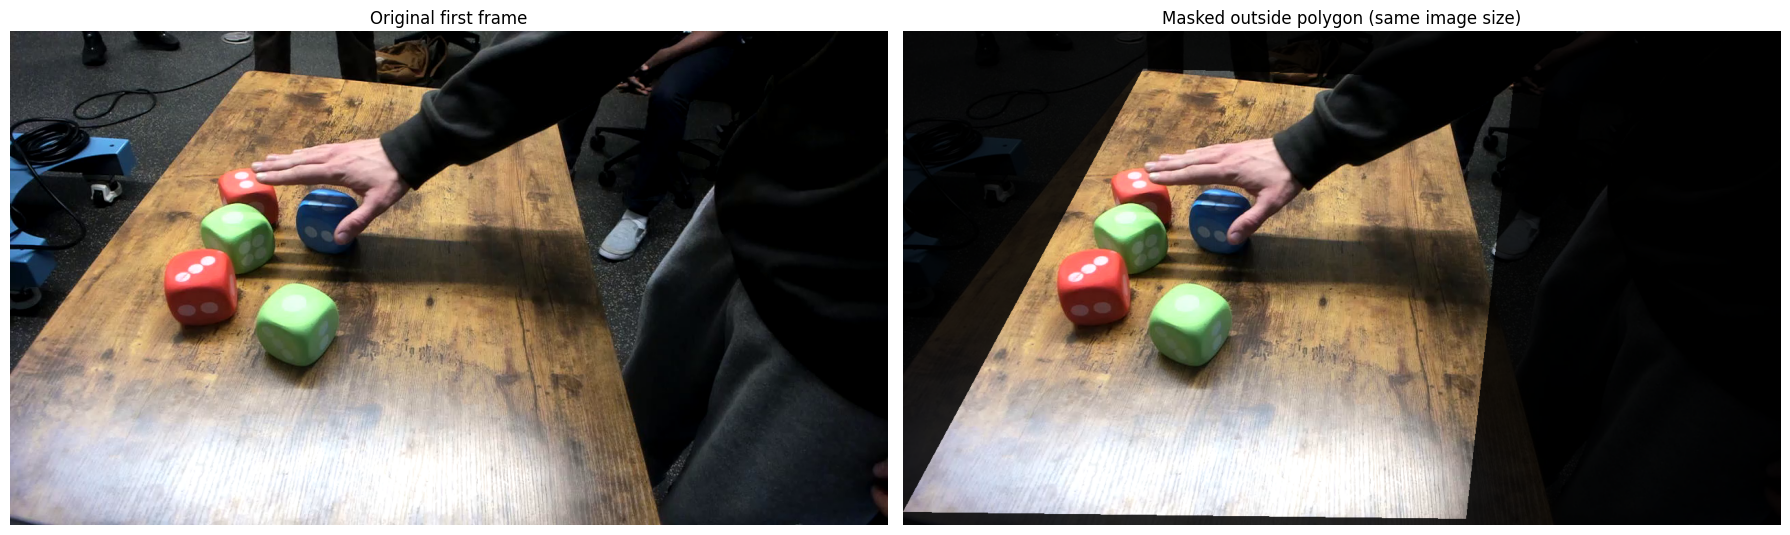

In [125]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

VIDEO_PATH = "Videos/data8.mov"

# -----------------------------
# ROI polygon defined by 4 points (px)
# -----------------------------
P1 = (350,  55)   # (x, y)
P2 = (890, 70)
P3 = (820, 710)
P4 = (0,  700)

DARKEN_OUTSIDE = True   # set False if you want hard-black outside
DARKEN_FACTOR = 0.15    # 0..1 (smaller = darker)

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

ret, frame_bgr = cap.read()
cap.release()
if not ret:
    raise RuntimeError("Could not read first frame.")

H, W = frame_bgr.shape[:2]

pts = np.array([P1, P2, P3, P4], dtype=np.int32)
pts[:, 0] = np.clip(pts[:, 0], 0, W - 1)
pts[:, 1] = np.clip(pts[:, 1], 0, H - 1)

# Build polygon mask (same size as frame)
poly_mask = np.zeros((H, W), dtype=np.uint8)
cv2.fillPoly(poly_mask, [pts], 255)

# Apply mask without changing image size
masked = frame_bgr.copy()
if DARKEN_OUTSIDE:
    outside = (poly_mask == 0)
    masked[outside] = (masked[outside] * DARKEN_FACTOR).astype(np.uint8)
else:
    masked[poly_mask == 0] = 0

# Visualization: draw polygon outline + points
vis = masked.copy()
#cv2.polylines(vis, [pts.reshape(-1, 1, 2)], isClosed=True, color=(0, 255, 255), thickness=3)

#for i, (x, y) in enumerate(pts):
#    cv2.circle(vis, (int(x), int(y)), 6, (255, 0, 255), -1)
#    cv2.putText(vis, f"P{i+1}", (int(x)+8, int(y)-8),
#                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,255), 2, cv2.LINE_AA)

# Show original vs masked (same size)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.title("Original first frame")
plt.imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Masked outside polygon (same image size)")
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.savefig("proj2_figs/ROI.pdf")
plt.show()

## Tracking the Objects

We use our homemade vision model to detect the objects and save the data to a df to predict the trajectories smoothly


In [116]:
import cv2
import numpy as np
import pandas as pd

TEST = "data2"

# -------------------------
# Config
# -------------------------
VIDEO_PATH = f"Videos/{TEST}.mov"
# Output CSV
SAVE_CSV_PATH = f"Data/{TEST}.csv"

PATCH = 64
STRIDE = 16
TOPK = 2
TOPK_BLUE = 1

P1 = (320,  55)   # (x, y)
P2 = (890, 70)
P3 = (820, 710)
P4 = (0,  600)

# Apply mask appearance
DARKEN_OUTSIDE_ROI_FOR_DISPLAY = True
DARKEN_FACTOR = 0.15  # 0..1

# Larger suppression neighborhood
MIN_SEP_SCALE = 1.15
MIN_SEP_PX = int(MIN_SEP_SCALE * PATCH)

# Evidence tuning
DARK_THRESH = 40
OPP_W = 0.6

# Playback
FPS_OVERRIDE = None
WINDOW_NAME = "Polygon-ROI masked color-density boxes"

# Visualization options
DRAW_NEIGHBORHOOD = True
NEIGHBORHOOD_SCALE = 0.55  # circle radius relative to MIN_SEP_PX (visual only)

# -------------------------
# Helpers
# -------------------------
def polygon_mask(H, W, pts4):
    pts = np.array(pts4, dtype=np.int32)
    pts[:, 0] = np.clip(pts[:, 0], 0, W - 1)
    pts[:, 1] = np.clip(pts[:, 1], 0, H - 1)
    m = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(m, [pts], 255)
    return m, pts

def build_evidence_maps(rgb_f32, roi_mask_u8):
    # roi_mask_u8: 0/255
    roi_mask_f32 = (roi_mask_u8.astype(np.float32) / 255.0)

    R, G, B = rgb_f32[..., 0], rgb_f32[..., 1], rgb_f32[..., 2]
    brightness = (R + G + B) / 3.0
    mask_dark = (brightness > DARK_THRESH).astype(np.float32)

    mask = roi_mask_f32 * mask_dark

    red_score   = np.clip((R - OPP_W*G - OPP_W*B) * mask, 0, None)
    green_score = np.clip((G - OPP_W*R - OPP_W*B) * mask, 0, None)
    blue_score  = np.clip((B - OPP_W*R - OPP_W*G) * mask, 0, None)
    return red_score, green_score, blue_score

def density_from_score(score, patch, ks_pool):
    kernel = np.ones((ks_pool, ks_pool), np.uint8)
    pooled = cv2.dilate(score, kernel)
    density = cv2.boxFilter(pooled, ddepth=-1, ksize=(patch, patch), normalize=True)
    return density

def topk_separated_from_density(density, label, k, patch, stride, min_sep_px):
    H, W = density.shape
    if H < patch or W < patch:
        return []

    ys = np.arange(0, H - patch + 1, stride)
    xs = np.arange(0, W - patch + 1, stride)

    cy, cx = patch // 2, patch // 2
    grid = np.zeros((len(ys), len(xs)), dtype=np.float32)
    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            grid[i, j] = density[y + cy, x + cx]

    grid_work = grid.copy()
    picks = []

    min_sep_cells = int(np.ceil(min_sep_px / float(stride)))
    min_sep_cells = max(1, min_sep_cells)

    for _ in range(min(k, grid_work.size)):
        max_val = float(grid_work.max())
        if max_val <= 1e-9:
            break

        idx = int(np.argmax(grid_work))
        i = idx // grid_work.shape[1]
        j = idx %  grid_work.shape[1]

        y = int(ys[i])
        x = int(xs[j])
        score = float(grid_work[i, j])

        cx_pix = x + patch // 2
        cy_pix = y + patch // 2
        picks.append((x, y, score, label, cx_pix, cy_pix))

        i0 = max(0, i - min_sep_cells)
        i1 = min(grid_work.shape[0], i + min_sep_cells + 1)
        j0 = max(0, j - min_sep_cells)
        j1 = min(grid_work.shape[1], j + min_sep_cells + 1)
        grid_work[i0:i1, j0:j1] = 0.0

    return picks

def process_frame_bgr(frame_bgr):
    H, W = frame_bgr.shape[:2]

    # Build polygon mask for this frame size
    roi_u8, pts = polygon_mask(H, W, [P1, P2, P3, P4])

    # RGB float32 for scoring
    rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)

    # Compute evidence scores (already zeroed outside polygon)
    red_score, green_score, blue_score = build_evidence_maps(rgb, roi_u8)

    ks_pool = max(3, (PATCH // 8) | 1)
    red_density   = density_from_score(red_score,   PATCH, ks_pool)
    green_density = density_from_score(green_score, PATCH, ks_pool)
    blue_density  = density_from_score(blue_score,  PATCH, ks_pool)

    boxes = []
    boxes += topk_separated_from_density(red_density,   "RED",   TOPK,      PATCH, STRIDE, MIN_SEP_PX)
    boxes += topk_separated_from_density(green_density, "GREEN", TOPK,      PATCH, STRIDE, MIN_SEP_PX)
    boxes += topk_separated_from_density(blue_density,  "BLUE",  TOPK_BLUE, PATCH, STRIDE, MIN_SEP_PX)

    # Output frame for display (keep original size)
    out = frame_bgr.copy()

    # Apply display mask (darken or black outside polygon)
    if DARKEN_OUTSIDE_ROI_FOR_DISPLAY:
        outside = (roi_u8 == 0)
        out[outside] = (out[outside] * DARKEN_FACTOR).astype(np.uint8)
    else:
        out[roi_u8 == 0] = 0

    # Draw polygon outline
    cv2.polylines(out, [pts.reshape(-1, 1, 2)], isClosed=True, color=(0, 255, 255), thickness=2)

    # BGR colors
    draw_color = {
        "RED":   (0, 0, 255),
        "GREEN": (0, 255, 0),
        "BLUE":  (255, 80, 0),
    }

    # Draw boxes + neighborhood circles
    r_vis = int(max(2, NEIGHBORHOOD_SCALE * MIN_SEP_PX))
    for (x, y, s, name, cx_pix, cy_pix) in boxes:
        c = draw_color[name]
        cv2.rectangle(out, (x, y), (x + PATCH, y + PATCH), c, 3)
        cv2.putText(out, f"{name} {s:.3f}", (x, max(20, y - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, c, 2, cv2.LINE_AA)
        if DRAW_NEIGHBORHOOD:
            cv2.circle(out, (int(cx_pix), int(cy_pix)), r_vis, c, 2)

    # IMPORTANT: return boxes too, so we can log to a dataframe
    return out, boxes

# -------------------------
# Video loop + DataFrame logging
# -------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps <= 1e-6:
    fps = 30.0
if FPS_OVERRIDE is not None:
    fps = float(FPS_OVERRIDE)

delay_ms = max(1, int(round(1000.0 / fps)))

print(f"Playing: {VIDEO_PATH}")
print(f"FPS used: {fps:.2f} | delay={delay_ms}ms | PATCH={PATCH}, STRIDE={STRIDE}, MIN_SEP_PX={MIN_SEP_PX}")
print("Controls: q=quit, space=pause/resume")

# Collect rows here, then build DataFrame at the end (faster than df.append)
rows = []
frame_idx = -1

paused = False
while True:
    if not paused:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        vis, boxes = process_frame_bgr(frame)

        # Log every detection in this frame
        for (x, y, s, name, cx_pix, cy_pix) in boxes:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + PATCH), int(y + PATCH)
            rows.append({
                "frame": frame_idx,
                "label": name,          # "RED"/"GREEN"/"BLUE"
                "score": float(s),
                "x1": x1, "y1": y1,
                "x2": x2, "y2": y2,
                "cx": int(cx_pix),
                "cy": int(cy_pix),
                "patch": int(PATCH),
            })

        cv2.imshow(WINDOW_NAME, vis)

    key = cv2.waitKey(0 if paused else delay_ms) & 0xFF
    if key == ord('q'):
        break
    if key == ord(' '):
        paused = not paused

cap.release()
cv2.destroyAllWindows()

# Build dataframe
df = pd.DataFrame(rows, columns=[
    "frame", "label", "score",
    "x1", "y1", "x2", "y2",
    "cx", "cy", "patch"
])

print(f"Detections: {len(df)} rows across {df['frame'].nunique() if len(df) else 0} frames")
print(df.head(10))

# Save to CSV for downstream tracker
#df.to_csv(SAVE_CSV_PATH, index=False)
#print(f"Saved: {SAVE_CSV_PATH}")

Playing: Videos/data2.mov
FPS used: 57.60 | delay=17ms | PATCH=64, STRIDE=16, MIN_SEP_PX=73
Controls: q=quit, space=pause/resume
Detections: 6195 rows across 1239 frames
   frame  label       score   x1   y1   x2   y2   cx   cy  patch
0      0    RED  111.292236  240  160  304  224  272  192     64
1      0    RED   75.529739  256  256  320  320  288  288     64
2      0  GREEN   45.719185  336  208  400  272  368  240     64
3      0  GREEN    5.346436  304  112  368  176  336  144     64
4      0   BLUE   66.222168  304  128  368  192  336  160     64
5      1    RED  111.213326  240  160  304  224  272  192     64
6      1    RED   76.204147  256  256  320  320  288  288     64
7      1  GREEN   45.577827  336  208  400  272  368  240     64
8      1  GREEN    5.272021  304  112  368  176  336  144     64
9      1   BLUE   65.436913  304  128  368  192  336  160     64
Saved: Data/data2.csv


### Predicting the Trajectories
Was unnecessarily difficult before defining initial and final positions

In [126]:
# DROP-IN UPDATE: Robust occlusion handling with
# (1) appearance (HSV hist) re-ID, (2) velocity decay + covariance inflation,
# (3) reacquire mode after long misses, (4) combined association cost.
#
# Assumes CSV has: frame,label,score and either (cx,cy) or (x1,y1,x2,y2).
# If no box cols, we crop a PATCH-sized square around (cx,cy) for appearance.

import cv2
import numpy as np
import pandas as pd
import os

# -------------------------
# Paths / config (EDIT)
# -------------------------
VIDEO_PATH = f"Videos/{TEST}.mov"
CSV_PATH   = f"Data/{TEST}.csv"
WINDOW_NAME = "Tracked objects (robust occlusion + appearance)"

EXPECTED = {"RED": 2, "GREEN": 2, "BLUE": 1}

# Playback
FPS_OVERRIDE = None

# Kalman + occlusion behavior
Q_POS = 2.0
Q_VEL = 6.0
R_MEAS = 10.0

MAX_MISS = 120            # allow long occlusions
REACQUIRE_AFTER = 12      # after this many misses, loosen distance gate but require appearance
VEL_DECAY = 0.90          # per-missed-frame velocity decay (0.85-0.98 typical)
COV_INFLATE_POS = 8.0     # added to P xx/yy per missed frame
COV_INFLATE_VEL = 15.0    # added to P vx/vy per missed frame

# Association gating
BASE_GATE_PX = {"RED": 70, "GREEN": 70, "BLUE": 90}  # tight gate when recently seen
GATE_GROWTH_PX_PER_MISS = 6.0                         # gate widens with miss_count

# Appearance feature (HSV hist)
H_BINS, S_BINS = 8, 8
APP_EMA = 0.25           # how fast track appearance updates (0.1-0.4)
W_POS = 0.60             # position weight in cost
W_APP = 0.35             # appearance weight in cost
W_SCORE = 0.05           # score weight (small bias)
MIN_APP_SIM_REACQUIRE = 0.55  # stricter after long occlusion (0.45-0.75)
MIN_APP_SIM_ALWAYS = 0.20     # reject obviously wrong matches

# Drawing
DRAW_TRAILS = True
TRAIL_LEN = 250
DRAW_COLOR = {"RED": (0,0,255), "GREEN": (0,255,0), "BLUE": (255,80,0)}

# If CSV lacks x1..y2, we’ll use PATCH around centroid for appearance crop
DEFAULT_PATCH = 64

# -------------------------
# Helpers
# -------------------------
def safe_crop(frame_bgr, x1, y1, x2, y2):
    H, W = frame_bgr.shape[:2]
    x1 = int(max(0, min(W-1, x1)))
    y1 = int(max(0, min(H-1, y1)))
    x2 = int(max(0, min(W,   x2)))
    y2 = int(max(0, min(H,   y2)))
    if x2 <= x1 or y2 <= y1:
        return None
    return frame_bgr[y1:y2, x1:x2]

def hsv_hist_feat(patch_bgr, h_bins=8, s_bins=8):
    """
    Returns a normalized HSV histogram vector (H×S bins) as float32.
    """
    if patch_bgr is None or patch_bgr.size == 0:
        return None
    hsv = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1], None, [h_bins, s_bins], [0, 180, 0, 256])
    hist = hist.astype(np.float32)
    s = float(hist.sum())
    if s <= 1e-6:
        return None
    hist /= s
    return hist.reshape(-1)

def cosine_sim(a, b):
    if a is None or b is None:
        return None
    a = a.astype(np.float32)
    b = b.astype(np.float32)
    na = float(np.linalg.norm(a))
    nb = float(np.linalg.norm(b))
    if na <= 1e-6 or nb <= 1e-6:
        return None
    return float(np.dot(a, b) / (na * nb))

def try_hungarian(cost):
    """
    Returns (row_ind, col_ind) using scipy if available; else None.
    """
    try:
        from scipy.optimize import linear_sum_assignment
        return linear_sum_assignment(cost)
    except Exception:
        return None

# -------------------------
# Kalman filter (x,y,vx,vy) + occlusion logic
# -------------------------
class Track:
    def __init__(self, dt=1.0, q_pos=2.0, q_vel=6.0, r_meas=10.0):
        self.dt = float(dt)
        self.kf = KalmanXYV(dt=dt, q_pos=q_pos, q_vel=q_vel, r_meas=r_meas)
        self.miss = 0
        self.appearance = None  # HSV hist vector
        self.initialized = False

    def init(self, cx, cy, app=None):
        self.kf.init(cx, cy)
        self.initialized = True
        self.miss = 0
        self.appearance = app

    def predict(self):
        if not self.initialized:
            return None
        # standard predict
        self.kf.predict()
        # if missed, apply velocity decay + covariance inflation
        if self.miss > 0:
            decay = float(VEL_DECAY ** min(self.miss, 50))
            self.kf.x[2,0] *= decay
            self.kf.x[3,0] *= decay
            # inflate covariance to reflect uncertainty while occluded
            self.kf.P[0,0] += COV_INFLATE_POS * self.miss
            self.kf.P[1,1] += COV_INFLATE_POS * self.miss
            self.kf.P[2,2] += COV_INFLATE_VEL * self.miss
            self.kf.P[3,3] += COV_INFLATE_VEL * self.miss
        return self.pos()

    def update(self, cx, cy, app=None):
        if not self.initialized:
            self.init(cx, cy, app=app)
            return self.pos()
        self.kf.update(cx, cy)
        self.miss = 0
        # update appearance with EMA
        if app is not None:
            if self.appearance is None:
                self.appearance = app
            else:
                self.appearance = (1.0 - APP_EMA) * self.appearance + APP_EMA * app
        return self.pos()

    def mark_missed(self):
        if self.initialized:
            self.miss += 1

    def pos(self):
        return self.kf.pos()

class KalmanXYV:
    def __init__(self, dt=1.0, q_pos=2.0, q_vel=6.0, r_meas=10.0):
        self.dt = float(dt)
        self.x = None
        self.P = None

        dt = self.dt
        self.F = np.array([[1, 0, dt, 0 ],
                           [0, 1, 0,  dt],
                           [0, 0, 1,  0 ],
                           [0, 0, 0,  1 ]], dtype=np.float32)
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]], dtype=np.float32)
        self.Q = np.diag([q_pos, q_pos, q_vel, q_vel]).astype(np.float32)
        self.R = np.diag([r_meas, r_meas]).astype(np.float32)
        self.I = np.eye(4, dtype=np.float32)

    def init(self, cx, cy):
        self.x = np.array([[cx], [cy], [0.0], [0.0]], dtype=np.float32)
        self.P = np.diag([250.0, 250.0, 600.0, 600.0]).astype(np.float32)

    def predict(self):
        if self.x is None:
            return None
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x.copy()

    def update(self, cx, cy):
        if self.x is None:
            self.init(cx, cy)
            return self.x.copy()
        z = np.array([[cx], [cy]], dtype=np.float32)
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + (K @ y)
        self.P = (self.I - K @ self.H) @ self.P
        return self.x.copy()

    def pos(self):
        if self.x is None:
            return None
        return float(self.x[0,0]), float(self.x[1,0])

# -------------------------
# Load detections
# -------------------------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

need = {"frame", "label"}
if not need.issubset(df.columns):
    raise ValueError(f"CSV must contain {need}, got {list(df.columns)}")

df["label"] = df["label"].astype(str).str.upper()
if "score" not in df.columns:
    df["score"] = 1.0

has_centroid = {"cx","cy"}.issubset(df.columns)
has_box = {"x1","y1","x2","y2"}.issubset(df.columns)

if not has_centroid and has_box:
    df["cx"] = (df["x1"] + df["x2"]) / 2.0
    df["cy"] = (df["y1"] + df["y2"]) / 2.0
    has_centroid = True

if not has_centroid:
    raise ValueError("CSV must contain (cx,cy) or (x1,y1,x2,y2).")

if "patch" not in df.columns:
    df["patch"] = DEFAULT_PATCH

# Build per-frame detections list; we’ll compute appearance on-the-fly from the current frame.
# Format per det: dict(label,cx,cy,score,x1,y1,x2,y2,patch)
frame_to_dets = {}
for r in df.itertuples(index=False):
    f = int(getattr(r, "frame"))
    lab = getattr(r, "label")
    if lab not in EXPECTED:
        continue
    det = {
        "label": lab,
        "cx": float(getattr(r, "cx")),
        "cy": float(getattr(r, "cy")),
        "score": float(getattr(r, "score")),
        "patch": int(getattr(r, "patch")) if hasattr(r, "patch") else DEFAULT_PATCH
    }
    if has_box:
        det["x1"] = int(getattr(r, "x1"))
        det["y1"] = int(getattr(r, "y1"))
        det["x2"] = int(getattr(r, "x2"))
        det["y2"] = int(getattr(r, "y2"))
    frame_to_dets.setdefault(f, []).append(det)

# -------------------------
# Initialize tracks
# -------------------------
tracks = {lab: [Track(dt=1.0, q_pos=Q_POS, q_vel=Q_VEL, r_meas=R_MEAS) for _ in range(n)]
          for lab, n in EXPECTED.items()}
trails = {lab: [[] for _ in range(n)] for lab, n in EXPECTED.items()}

# Collect predicted trajectory rows here
trajectory_rows = []

# -------------------------
# Association: combined cost matrix (pos + appearance + score)
# -------------------------
def build_cost_matrix(track_list, det_list, lab):
    """
    Returns cost matrix (T x D) and gating mask for infeasible matches.
    """
    T = len(track_list)
    D = len(det_list)
    if D == 0:
        return None, None

    cost = np.full((T, D), 1e9, dtype=np.float32)
    feasible = np.zeros((T, D), dtype=np.uint8)

    for i, trk in enumerate(track_list):
        p = trk.pos()
        # uninitialized track: allow match to any detection (cost based mostly on score)
        if p is None:
            for j, det in enumerate(det_list):
                # encourage high score and reasonable position within ROI implicitly
                score_term = 1.0 - float(det["score"])
                cost[i, j] = 0.25 + 0.75 * score_term
                feasible[i, j] = 1
            continue

        tx, ty = p
        gate = BASE_GATE_PX[lab] + GATE_GROWTH_PX_PER_MISS * float(trk.miss)
        for j, det in enumerate(det_list):
            dx = det["cx"] - tx
            dy = det["cy"] - ty
            dist = float(np.hypot(dx, dy))

            # appearance sim if available (will be filled in later after we compute app)
            app_sim = det.get("app_sim", None)
            if app_sim is None:
                app_sim = 0.0

            # gating: during reacquire require stronger appearance
            if trk.miss >= REACQUIRE_AFTER:
                if dist > gate * 2.0:
                    continue
                if app_sim < MIN_APP_SIM_REACQUIRE:
                    continue
            else:
                if dist > gate:
                    continue
                if app_sim < MIN_APP_SIM_ALWAYS:
                    continue

            # normalized terms
            pos_term = dist / max(1.0, gate)
            app_term = 1.0 - app_sim
            score_term = 1.0 - float(det["score"])

            c = W_POS * pos_term + W_APP * app_term + W_SCORE * score_term
            cost[i, j] = c
            feasible[i, j] = 1

    return cost, feasible

def assign_tracks(track_list, det_list, lab):
    """
    Returns assignment list of length T: assigned det index or None.
    """
    T = len(track_list)
    if len(det_list) == 0:
        return [None] * T

    cost, feasible = build_cost_matrix(track_list, det_list, lab)
    # If nothing feasible, return None assignments
    if feasible is None or feasible.sum() == 0:
        return [None] * T

    # Prefer Hungarian if available, else greedy
    hung = try_hungarian(cost)
    assigned = [None] * T
    used_d = set()

    if hung is not None:
        rows, cols = hung
        for r, c in zip(rows, cols):
            if feasible[r, c] == 0:
                continue
            # basic sanity threshold
            if cost[r, c] > 3.0:
                continue
            assigned[r] = int(c)
            used_d.add(int(c))
        # leave others None
        return assigned

    # Greedy: choose best pairs by ascending cost
    pairs = []
    for i in range(T):
        for j in range(len(det_list)):
            if feasible[i, j]:
                pairs.append((float(cost[i, j]), i, j))
    pairs.sort(key=lambda x: x[0])
    for c, i, j in pairs:
        if assigned[i] is not None:
            continue
        if j in used_d:
            continue
        if c > 3.0:
            continue
        assigned[i] = j
        used_d.add(j)
    return assigned

# -------------------------
# Video playback + tracking
# -------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps <= 1e-6:
    fps = 30.0
if FPS_OVERRIDE is not None:
    fps = float(FPS_OVERRIDE)
delay_ms = max(1, int(round(1000.0 / fps)))

print(f"Video: {VIDEO_PATH}")
print(f"CSV:   {CSV_PATH}")
print(f"FPS used: {fps:.2f} (delay {delay_ms} ms)")
print("Controls: q=quit, space=pause/resume")

paused = False
frame_idx = -1

while True:
    if not paused:
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        dets = frame_to_dets.get(frame_idx, [])

        # group detections per color and compute appearance + app_sim per track (per color)
        dets_by_lab = {lab: [] for lab in EXPECTED}
        for d in dets:
            dets_by_lab[d["label"]].append(d)

        # For each label: predict tracks, compute det appearance + sim, assign, update
        for lab, tlist in tracks.items():
            # Predict & mark missed by default (we’ll reset to 0 on update)
            for trk in tlist:
                if trk.initialized:
                    trk.predict()
                    trk.mark_missed()

            # Build detection appearance features from current frame
            lab_dets = dets_by_lab.get(lab, [])
            for det in lab_dets:
                if has_box and all(k in det for k in ("x1","y1","x2","y2")):
                    crop = safe_crop(frame, det["x1"], det["y1"], det["x2"], det["y2"])
                else:
                    p = int(det.get("patch", DEFAULT_PATCH))
                    cx, cy = float(det["cx"]), float(det["cy"])
                    x1 = int(round(cx - p/2)); y1 = int(round(cy - p/2))
                    x2 = int(round(cx + p/2)); y2 = int(round(cy + p/2))
                    crop = safe_crop(frame, x1, y1, x2, y2)
                det["app"] = hsv_hist_feat(crop, H_BINS, S_BINS)

            # Precompute app_sim for each det relative to each track? (we do max sim to track in cost build)
            # We’ll compute det["app_sim_to_track_i"] on the fly by setting det["app_sim"] per track during cost build.
            # To do that, we temporarily compute a list of det app vectors only.
            # We'll implement by attaching a per-track sim during cost build:
            # (quick hack: for each track, temporarily set det["app_sim"] before building cost row)

            # If no dets, continue (tracks coast with decay)
            if len(lab_dets) == 0:
                continue

            # For association, we need per-track app_sim inside build_cost_matrix.
            # We'll compute a "best effort" sim per det by comparing with the track’s stored appearance
            # in build_cost_matrix by overwriting det["app_sim"] for each track row.
            # -> easiest: create a wrapper that sets det["app_sim"] each row.
            # We'll just do it in-place per row by looping, building cost manually here.

            T = len(tlist)
            D = len(lab_dets)
            cost = np.full((T, D), 1e9, dtype=np.float32)
            feasible = np.zeros((T, D), dtype=np.uint8)

            for i, trk in enumerate(tlist):
                p = trk.pos()
                if p is None:
                    # uninitialized: prefer high score
                    for j, det in enumerate(lab_dets):
                        score_term = 1.0 - float(det["score"])
                        cost[i, j] = 0.25 + 0.75 * score_term
                        feasible[i, j] = 1
                    continue

                tx, ty = p
                gate = BASE_GATE_PX[lab] + GATE_GROWTH_PX_PER_MISS * float(trk.miss)

                for j, det in enumerate(lab_dets):
                    dx = det["cx"] - tx
                    dy = det["cy"] - ty
                    dist = float(np.hypot(dx, dy))

                    app_sim = cosine_sim(trk.appearance, det.get("app", None))
                    if app_sim is None:
                        app_sim = 0.0

                    # gating rules
                    if trk.miss >= REACQUIRE_AFTER:
                        if dist > gate * 2.0:
                            continue
                        if app_sim < MIN_APP_SIM_REACQUIRE:
                            continue
                    else:
                        if dist > gate:
                            continue
                        if app_sim < MIN_APP_SIM_ALWAYS:
                            continue

                    pos_term = dist / max(1.0, gate)
                    app_term = 1.0 - app_sim
                    score_term = 1.0 - float(det["score"])
                    c = W_POS * pos_term + W_APP * app_term + W_SCORE * score_term

                    cost[i, j] = c
                    feasible[i, j] = 1

            if feasible.sum() == 0:
                continue

            # Assignment (Hungarian if available)
            assigned = [None] * T
            hung = try_hungarian(cost)
            used_d = set()

            if hung is not None:
                rows, cols = hung
                for r, c in zip(rows, cols):
                    if feasible[r, c] == 0:
                        continue
                    if float(cost[r, c]) > 3.0:
                        continue
                    assigned[int(r)] = int(c)
                    used_d.add(int(c))
            else:
                pairs = []
                for i in range(T):
                    for j in range(D):
                        if feasible[i, j]:
                            pairs.append((float(cost[i, j]), i, j))
                pairs.sort(key=lambda x: x[0])
                for c, i, j in pairs:
                    if assigned[i] is not None or j in used_d:
                        continue
                    if c > 3.0:
                        continue
                    assigned[i] = j
                    used_d.add(j)

            # Update tracks with assigned detections (reset miss to 0)
            for i, j in enumerate(assigned):
                trk = tlist[i]
                if j is None:
                    # if too long missed, you can optionally "drop" track; we keep it alive
                    if trk.miss > MAX_MISS:
                        trk.initialized = False
                        trk.kf.x = None
                        trk.kf.P = None
                        trk.miss = 0
                        trk.appearance = None
                    continue
                det = lab_dets[j]
                trk.update(det["cx"], det["cy"], app=det.get("app", None))

        # -------------------------
        # Draw overlays
        # -------------------------
        vis = frame.copy()

        if DRAW_TRAILS:
            for lab, tlist in tracks.items():
                c = DRAW_COLOR[lab]
                for i, trk in enumerate(tlist):
                    p = trk.pos()
                    if p is None:
                        continue
                    x, y = int(round(p[0])), int(round(p[1]))
                    trails[lab][i].append((x, y))
                    if len(trails[lab][i]) > TRAIL_LEN:
                        trails[lab][i] = trails[lab][i][-TRAIL_LEN:]
                    if len(trails[lab][i]) >= 2:
                        cv2.polylines(vis, [np.array(trails[lab][i], dtype=np.int32)], False, c, 2)

        for lab, tlist in tracks.items():
            c = DRAW_COLOR[lab]
            for i, trk in enumerate(tlist):
                p = trk.pos()
                if p is None:
                    continue
                x, y = int(round(p[0])), int(round(p[1]))

                trajectory_rows.append({
                    "frame": frame_idx,
                    "label": lab,
                    "track_id": i,              # 0 or 1 for red/green, 0 for blue
                    "x_pred": float(p[0]),
                    "y_pred": float(p[1]),
                    "miss_count": trk.miss,     # how long it’s been occluded
                })
                
                # thicker outline if currently "occluded" (miss>0)
                r = 10
                cv2.circle(vis, (x, y), r, c, -1)
                if trk.miss > 0:
                    cv2.circle(vis, (x, y), r+5, c, 2)
                cv2.putText(vis, f"{lab[0]}{i+1} m{trk.miss}", (x + 12, y - 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, c, 2, cv2.LINE_AA)

        cv2.putText(vis, f"frame {frame_idx}", (20, 35),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2, cv2.LINE_AA)

        cv2.imshow(WINDOW_NAME, vis)

    key = cv2.waitKey(0 if paused else delay_ms) & 0xFF
    if key == ord('q'):
        break
    if key == ord(' '):
        paused = not paused

cap.release()
cv2.destroyAllWindows()

# -------------------------
# Save predicted trajectories
# -------------------------
traj_df = pd.DataFrame(trajectory_rows)

print("Saved trajectory rows:", len(traj_df))
print(traj_df.head())

traj_df.to_csv(f"Data/{TEST}_trajectories.csv", index=False)
print(f"Saved: {TEST}_trajectories.csv")

print("Done.")

Video: Videos/data2.mov
CSV:   Data/data2.csv
FPS used: 57.60 (delay 17 ms)
Controls: q=quit, space=pause/resume
Saved trajectory rows: 5540
   frame  label  track_id  x_pred  y_pred  miss_count
0      0    RED         0   272.0   192.0           0
1      0    RED         1   288.0   288.0           0
2      0  GREEN         0   368.0   240.0           0
3      0  GREEN         1   336.0   144.0           0
4      0   BLUE         0   336.0   160.0           0
Saved: data2_trajectories.csv
Done.


### Smoothing the Predicted Trajectories

Doesn't Work

### Predicting Initial and Final Steps

Can we use the complete trajectory data to predict what the initial and final object states are and then work back to determine when the objects are moved?

object  color      init_x      init_y     final_x  final_y  \
0   blue_1   blue  452.266663  289.066681  688.000000    304.0   
1  green_1  green  350.399994  294.933319  688.000000    208.0   
2  green_2  green  448.000000  416.000000  688.000000    416.0   
3    red_1    red  288.000000  352.000000  697.599976    352.0   
4    red_2    red  341.866669  224.000000  688.000000    256.0   

   init_support_pts  final_support_pts  
0                30                 30  
1                30                 30  
2                21                 30  
3                30                 30  
4                30                 30

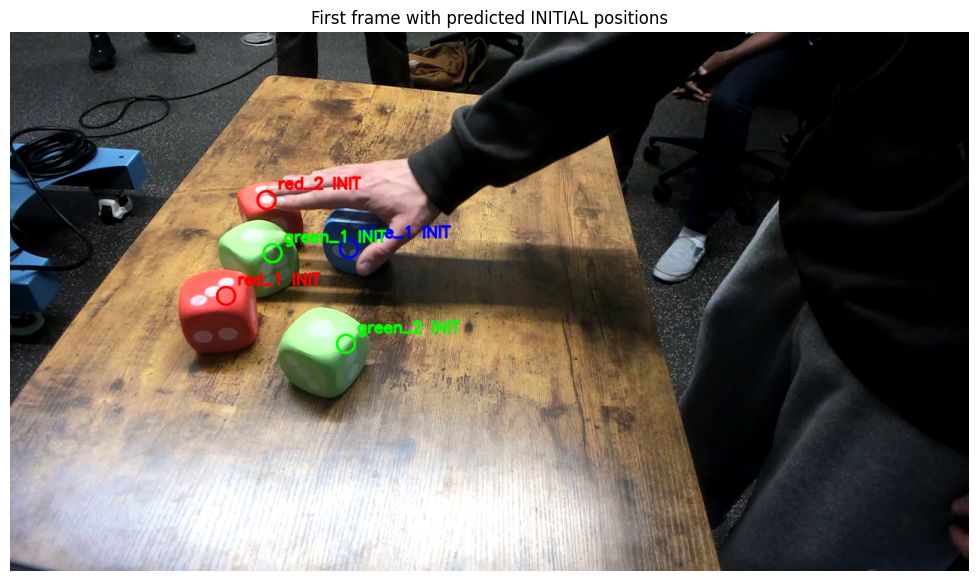

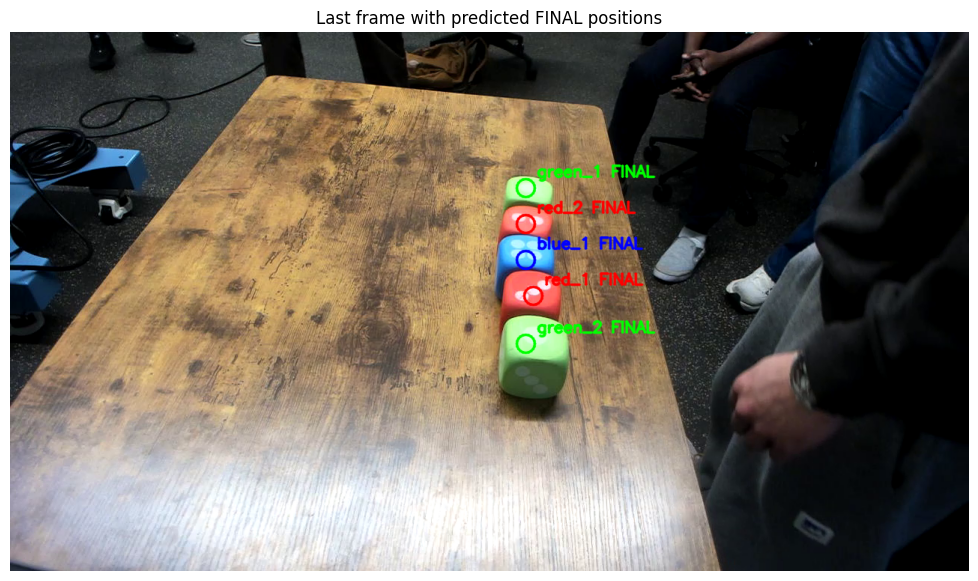

In [128]:
###### Notebook cell (drop-in): infer initial+final "resting" states from trajectories CSV
# and overlay on FIRST + LAST frames of a .mov reliably (without using frame index [-1])

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

TEST = "data8"

# ----------------------------
# 🔧 Set these paths
# ----------------------------
VIDEO_PATH = f"Videos/{TEST}.mov"
CSV_PATH   = f"Data/{TEST}.csv"

START_N = 30
END_N   = 30

# If you don't have track IDs in the CSV, we cluster per color and expect these counts:
EXPECTED_COUNTS = {"red": 2, "green": 2, "blue": 1}

# ----------------------------
# Helpers
# ----------------------------
def _pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Missing one of columns: {candidates}. Found: {list(df.columns)}")
    return None

def _compute_centers(df, x1c, y1c, x2c, y2c):
    df = df.copy()
    df["xc"] = (df[x1c].astype(float) + df[x2c].astype(float)) / 2.0
    df["yc"] = (df[y1c].astype(float) + df[y2c].astype(float)) / 2.0
    return df

def _weighted_centroid(points_xy, weights=None):
    if len(points_xy) == 0:
        return None
    pts = np.asarray(points_xy, dtype=np.float32)
    if weights is None:
        return pts.mean(axis=0)
    w = np.asarray(weights, dtype=np.float32).reshape(-1, 1)
    wsum = float(w.sum())
    if wsum <= 1e-9:
        return pts.mean(axis=0)
    return (pts * w).sum(axis=0) / wsum

def _dbscan(points_xy, eps, min_samples=6):
    """
    Lightweight DBSCAN (no sklearn). O(n^2) per window; usually fine.
    Returns cluster labels (>=0), -1 for noise.
    """
    pts = np.asarray(points_xy, dtype=np.float32)
    n = len(pts)
    if n == 0:
        return np.array([], dtype=int)

    d2 = np.sum((pts[:, None, :] - pts[None, :, :]) ** 2, axis=2)
    eps2 = eps * eps

    labels = np.full(n, -1, dtype=int)
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0
    neighbors = [np.where(d2[i] <= eps2)[0] for i in range(n)]

    for i in range(n):
        if visited[i]:
            continue
        visited[i] = True
        nbrs = neighbors[i]
        if len(nbrs) < min_samples:
            labels[i] = -1
            continue

        labels[i] = cluster_id
        seed = list(nbrs)
        k = 0
        while k < len(seed):
            j = seed[k]
            if not visited[j]:
                visited[j] = True
                nbrs_j = neighbors[j]
                if len(nbrs_j) >= min_samples:
                    for x in nbrs_j:
                        if x not in seed:
                            seed.append(x)
            if labels[j] == -1:
                labels[j] = cluster_id
            k += 1

        cluster_id += 1

    return labels

def _top_clusters(points_xy, weights, eps, min_samples, top_k):
    pts = np.asarray(points_xy, dtype=np.float32)
    if len(pts) == 0:
        return []

    labels = _dbscan(pts, eps=eps, min_samples=min_samples)
    clusters = []
    for lab in sorted(set(labels)):
        if lab == -1:
            continue
        idx = np.where(labels == lab)[0]
        c_pts = pts[idx]
        c_w = None if weights is None else np.asarray(weights, dtype=np.float32)[idx]
        support = len(idx)
        tw = float(c_w.sum()) if c_w is not None else float(support)
        clusters.append((c_pts, c_w, support, tw))

    if not clusters:
        c_w = None if weights is None else np.asarray(weights, dtype=np.float32)
        support = len(pts)
        tw = float(c_w.sum()) if c_w is not None else float(support)
        return [(pts, c_w, support, tw)]

    clusters.sort(key=lambda x: (x[3], x[2]), reverse=True)
    return clusters[:top_k]

def _draw_marker(img_bgr, xy, label, color_bgr, radius=10):
    x, y = int(round(float(xy[0]))), int(round(float(xy[1])))
    cv2.circle(img_bgr, (x, y), radius, color_bgr, thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(img_bgr, label, (x + radius + 3, y - radius - 3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color_bgr, 2, cv2.LINE_AA)

def read_first_frame(cap):
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = cap.read()
    return ret, frame

def read_last_frame_robust(cap, max_seek_back=300):
    """
    Robust last-frame read for .mov where CAP_PROP_FRAME_COUNT and random access can lie/fail.
    Strategy:
      1) Try reported frame_count-1 (if available)
      2) If fails: seek near end with increasingly larger step-backs
      3) If still fails: stream to end and keep last successful frame (guaranteed)
    """
    # Try the "official" way first (may fail on some .mov)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)
    if frame_count > 0:
        for back in [1, 2, 5, 10, 30, 60, 120, 240]:
            idx = max(frame_count - back, 0)
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret and frame is not None:
                # Read forward a bit to ensure we truly land near the end, keep last good
                last_good = frame
                while True:
                    r2, f2 = cap.read()
                    if not r2 or f2 is None:
                        break
                    last_good = f2
                return True, last_good

    # If frame_count is unknown or seek fails, try "seek back from end" heuristics
    # (Some backends support CAP_PROP_POS_AVI_RATIO)
    try:
        cap.set(cv2.CAP_PROP_POS_AVI_RATIO, 1.0)  # jump to end (may be ignored)
        ret, frame = cap.read()
        if ret and frame is not None:
            last_good = frame
            while True:
                r2, f2 = cap.read()
                if not r2 or f2 is None:
                    break
                last_good = f2
            return True, last_good
    except Exception:
        pass

    # Guaranteed fallback: stream from beginning to end and keep last frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    last_good = None
    ret_any = False
    while True:
        ret, frame = cap.read()
        if not ret or frame is None:
            break
        ret_any = True
        last_good = frame
    return (ret_any and last_good is not None), last_good

# ----------------------------
# Load CSV
# ----------------------------
df = pd.read_csv(CSV_PATH)

frame_c = _pick_col(df, ["frame", "Frame", "frame_idx", "t"])
color_c = _pick_col(df, ["color", "Color", "rgb_name", "label", "class_name"], required=False)
id_c    = _pick_col(df, ["track_id", "id", "object_id", "tracker_id"], required=False)

x1c = _pick_col(df, ["x1", "xmin", "left"])
y1c = _pick_col(df, ["y1", "ymin", "top"])
x2c = _pick_col(df, ["x2", "xmax", "right"])
y2c = _pick_col(df, ["y2", "ymax", "bottom"])
conf_c = _pick_col(df, ["conf", "confidence", "score"], required=False)

df = _compute_centers(df, x1c, y1c, x2c, y2c)

if color_c is not None:
    df[color_c] = df[color_c].astype(str).str.lower().str.strip()

if conf_c is not None:
    df["_w"] = pd.to_numeric(df[conf_c], errors="coerce").fillna(0.0).clip(0, 1)
else:
    df["_w"] = 1.0

# ----------------------------
# Load first + last video frames (ROBUST for .mov)
# ----------------------------
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

ret0, first_bgr = read_first_frame(cap)
if not ret0 or first_bgr is None:
    cap.release()
    raise RuntimeError("Could not read first frame from video.")

retL, last_bgr = read_last_frame_robust(cap)
cap.release()
if not retL or last_bgr is None:
    raise RuntimeError("Could not read last frame from video (robust method failed).")

H, W = first_bgr.shape[:2]
eps = 0.05 * min(W, H)
min_samples = 6

# ----------------------------
# Split into start/end windows
# ----------------------------
min_f = int(df[frame_c].min())
max_f = int(df[frame_c].max())

start_max = min_f + (START_N - 1)
end_min   = max_f - (END_N - 1)

df_start = df[df[frame_c].between(min_f, start_max)].copy()
df_end   = df[df[frame_c].between(end_min, max_f)].copy()

# ----------------------------
# Predict initial/final states
# ----------------------------
preds = []

if id_c is not None:
    group_cols = [id_c] + ([color_c] if color_c is not None else [])
    for key, g in df.groupby(group_cols):
        g0 = g[g[frame_c].between(min_f, start_max)]
        g1 = g[g[frame_c].between(end_min, max_f)]
        if len(g0) == 0 or len(g1) == 0:
            continue

        init_xy  = _weighted_centroid(g0[["xc", "yc"]].values, g0["_w"].values)
        final_xy = _weighted_centroid(g1[["xc", "yc"]].values, g1["_w"].values)
        if init_xy is None or final_xy is None:
            continue

        if isinstance(key, tuple):
            track_id = key[0]
            cval = key[1] if len(key) > 1 else "unknown"
        else:
            track_id = key
            cval = "unknown"

        preds.append({
            "object_key": f"id={track_id}",
            "color": cval,
            "init_xy": init_xy,
            "final_xy": final_xy,
            "init_support": len(g0),
            "final_support": len(g1),
        })

else:
    if color_c is None:
        raise RuntimeError("CSV has no track_id/id column AND no color column. Need at least one to separate objects.")

    for cval, exp_k in EXPECTED_COUNTS.items():
        s = df_start[df_start[color_c] == cval]
        e = df_end[df_end[color_c] == cval]
        if len(s) == 0 or len(e) == 0:
            continue

        s_clusters = _top_clusters(s[["xc", "yc"]].values, s["_w"].values, eps=eps, min_samples=min_samples, top_k=exp_k)
        e_clusters = _top_clusters(e[["xc", "yc"]].values, e["_w"].values, eps=eps, min_samples=min_samples, top_k=exp_k)

        s_centroids = [(_weighted_centroid(cpts, cw), sup, tw) for (cpts, cw, sup, tw) in s_clusters]
        e_centroids = [(_weighted_centroid(cpts, cw), sup, tw) for (cpts, cw, sup, tw) in e_clusters]
        s_centroids = [x for x in s_centroids if x[0] is not None]
        e_centroids = [x for x in e_centroids if x[0] is not None]
        if not s_centroids or not e_centroids:
            continue

        S = np.stack([x[0] for x in s_centroids], axis=0)
        E = np.stack([x[0] for x in e_centroids], axis=0)

        used_e = set()
        for i in range(len(S)):
            dists = np.linalg.norm(E - S[i], axis=1)
            order = np.argsort(dists)
            j = None
            for jj in order:
                if jj not in used_e:
                    j = jj
                    break
            if j is None:
                break
            used_e.add(j)

            preds.append({
                "object_key": f"{cval}_{i+1}",
                "color": cval,
                "init_xy": S[i],
                "final_xy": E[j],
                "init_support": int(s_centroids[i][1]),
                "final_support": int(e_centroids[j][1]),
            })

pred_df = pd.DataFrame([{
    "object": p["object_key"],
    "color": p["color"],
    "init_x": float(p["init_xy"][0]),
    "init_y": float(p["init_xy"][1]),
    "final_x": float(p["final_xy"][0]),
    "final_y": float(p["final_xy"][1]),
    "init_support_pts": p["init_support"],
    "final_support_pts": p["final_support"],
} for p in preds]).sort_values(["color", "object"]).reset_index(drop=True)

display(pred_df)

# ----------------------------
# Overlay on first/last frames
# ----------------------------
color_map_bgr = {
    "red": (0, 0, 255),
    "green": (0, 255, 0),
    "blue": (255, 0, 0),
    "unknown": (255, 255, 255),
}

first_out = first_bgr.copy()
last_out  = last_bgr.copy()

for _, r in pred_df.iterrows():
    cval = str(r["color"]).lower()
    bgr = color_map_bgr.get(cval, (255, 255, 255))
    _draw_marker(first_out, (r["init_x"], r["init_y"]),  f"{r['object']} INIT",  bgr, radius=12)
    _draw_marker(last_out,  (r["final_x"], r["final_y"]), f"{r['object']} FINAL", bgr, radius=12)

# Show frames
plt.figure(figsize=(16, 7))
plt.imshow(cv2.cvtColor(first_out, cv2.COLOR_BGR2RGB))
plt.title("First frame with predicted INITIAL positions")
plt.axis("off")
plt.savefig("proj2_figs/InitialPos.pdf")
plt.show()

plt.figure(figsize=(16, 7))
plt.imshow(cv2.cvtColor(last_out, cv2.COLOR_BGR2RGB))
plt.title("Last frame with predicted FINAL positions")
plt.axis("off")
plt.savefig("proj2_figs/FinalPos.pdf")
plt.show()

Successful for 3, 8, and 9!!! One off for 1 and 2. Failed 6. Start N = 70, End N = 70

Successful for 2, 3, 8, and 9. Start = 30, End = 30

Dropout data1 and data6

### Predicting moving points

In [3]:
# Notebook cell: predict WHEN each object is moved using init/final points + trajectories,
# then render an overlay video that draws a line from each object's init->final "box".
#
# Assumes you already have:
#   1) CSV_PATH + VIDEO_PATH
#   2) df loaded from CSV with frame + bbox cols (x1,y1,x2,y2) + color and/or track_id
#   3) pred_df from the previous cell with columns:
#        object, color, init_x, init_y, final_x, final_y
#
# Output:
#   - move_df: per object move_start_frame, move_end_frame
#   - writes "moves_overlay.mp4" with lines + markers + timestamps

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Video, display

# ----------------------------
# 🔧 Set these paths (must exist)
# ----------------------------
VIDEO_PATH = f"Videos/{TEST}.mov"
CSV_PATH   = f"Data/{TEST}.csv"
OUT_MP4    = f"Videos/{TEST}_moves.mp4"

# ----------------------------
# 🔧 Tuning knobs (optimize these)
# ----------------------------
# How close is "in the init box" / "in the final box"
R_INIT_FRAC  = 0.035   # radius around init point as fraction of min(W,H)
R_FINAL_FRAC = 0.040   # radius around final point (often slightly larger)
# Debounce: require K consecutive frames to confirm leaving/arriving
K_LEAVE  = 4
K_ARRIVE = 4
# After leaving, ignore "return-to-init" blips for a small cooldown window
LEAVE_COOLDOWN = 6

# If no track_id exists, we will build per-color tracks with expected counts:
EXPECTED_COUNTS = {"red": 2, "green": 2, "blue": 1}

# ----------------------------
# Helpers
# ----------------------------
def _pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Missing one of columns: {candidates}. Found: {list(df.columns)}")
    return None

def _compute_centers(df, x1c, y1c, x2c, y2c):
    out = df.copy()
    out["xc"] = (out[x1c].astype(float) + out[x2c].astype(float)) / 2.0
    out["yc"] = (out[y1c].astype(float) + out[y2c].astype(float)) / 2.0
    return out

def _runlen_first_true(mask, K):
    """Return first index i such that mask[i:i+K] are all True. Else None."""
    m = np.asarray(mask, dtype=bool)
    if len(m) < K:
        return None
    w = np.convolve(m.astype(int), np.ones(K, dtype=int), mode="valid")
    idx = np.where(w == K)[0]
    return int(idx[0]) if len(idx) else None

def _draw_marker(img_bgr, xy, label, color_bgr, radius=10):
    x, y = int(round(float(xy[0]))), int(round(float(xy[1])))
    cv2.circle(img_bgr, (x, y), radius, color_bgr, thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(img_bgr, label, (x + radius + 4, y - radius - 4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bgr, 2, cv2.LINE_AA)

def _draw_line(img_bgr, p0, p1, color_bgr, thickness=2):
    x0, y0 = int(round(float(p0[0]))), int(round(float(p0[1])))
    x1, y1 = int(round(float(p1[0]))), int(round(float(p1[1])))
    cv2.line(img_bgr, (x0, y0), (x1, y1), color_bgr, thickness, cv2.LINE_AA)

def _bgr_for_color(name):
    name = str(name).lower()
    return {"red": (0,0,255), "green": (0,255,0), "blue": (255,0,0)}.get(name, (255,255,255))

def _permute_assign_2(cost):
    """
    Solve 2x2 assignment by checking two permutations.
    cost shape (2,2). returns assignment indices [j_for_i0, j_for_i1]
    """
    a = cost[0,0] + cost[1,1]
    b = cost[0,1] + cost[1,0]
    return [0,1] if a <= b else [1,0]

# ----------------------------
# Load CSV + video info
# ----------------------------
df = pd.read_csv(CSV_PATH)

frame_c = _pick_col(df, ["frame", "Frame", "frame_idx", "t"])
color_c = _pick_col(df, ["color", "Color", "rgb_name", "label", "class_name"], required=False)
id_c    = _pick_col(df, ["track_id", "id", "object_id", "tracker_id"], required=False)

x1c = _pick_col(df, ["x1", "xmin", "left"])
y1c = _pick_col(df, ["y1", "ymin", "top"])
x2c = _pick_col(df, ["x2", "xmax", "right"])
y2c = _pick_col(df, ["y2", "ymax", "bottom"])
conf_c = _pick_col(df, ["conf", "confidence", "score"], required=False)

df = _compute_centers(df, x1c, y1c, x2c, y2c)
df[frame_c] = pd.to_numeric(df[frame_c], errors="coerce").astype(int)

if color_c is not None:
    df[color_c] = df[color_c].astype(str).str.lower().str.strip()
else:
    df["_color"] = "unknown"
    color_c = "_color"

# Open video to get W,H,FPS and for rendering
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
if not FPS or FPS <= 1e-6:
    FPS = 30.0

R_INIT  = R_INIT_FRAC  * min(W, H)
R_FINAL = R_FINAL_FRAC * min(W, H)

# ----------------------------
# Build per-object trajectories (xc,yc) across frames
#   Preferred: use track_id
#   Fallback: build per-color tracks by frame-wise assignment to predicted init points
# ----------------------------

# pred_df must exist from previous cell. If not, rebuild/paste it here.
# Expected columns: object,color,init_x,init_y,final_x,final_y
required_cols = {"object","color","init_x","init_y","final_x","final_y"}
if "pred_df" not in globals() or not required_cols.issubset(set(pred_df.columns)):
    raise RuntimeError("pred_df not found (or missing columns). Run the previous init/final prediction cell first.")

# Normalize pred_df color
pred_df = pred_df.copy()
pred_df["color"] = pred_df["color"].astype(str).str.lower().str.strip()

traj = {}  # object_key -> DataFrame with [frame, xc, yc, x1,y1,x2,y2]
if id_c is not None:
    # If pred_df.object is like "id=123", use that id
    # Otherwise, if pred_df.object doesn't match ids, just compute per id directly and label as id=...
    for tid, g in df.groupby(id_c):
        key = f"id={tid}"
        gg = g.sort_values(frame_c)[[frame_c, "xc","yc", x1c,y1c,x2c,y2c, color_c]].copy()
        traj[key] = gg.rename(columns={frame_c: "frame", color_c: "color"})

else:
    # Fallback: per-color tracking using predicted init points to seed consistent identities
    # Build init seeds per color from pred_df
    seeds = {}
    for cval, sub in pred_df.groupby("color"):
        # we will only build as many tracks as EXPECTED_COUNTS says (if present), else use sub count
        sub = sub.sort_values("object")
        seeds[cval] = sub[["object","init_x","init_y"]].values.tolist()

    # Group detections by frame within each color and assign to tracks
    for cval, seed_list in seeds.items():
        if len(seed_list) == 0:
            continue
        n_tracks = len(seed_list)
        # Create per-track "previous position" initialized to init point
        prev = [np.array([sx, sy], dtype=np.float32) for (_, sx, sy) in seed_list]
        # Storage per track
        track_rows = {obj: [] for (obj, _, _) in seed_list}

        dfc = df[df[color_c] == cval].sort_values(frame_c)
        for f, gf in dfc.groupby(frame_c):
            dets = gf[["xc","yc", x1c,y1c,x2c,y2c]].values.astype(np.float32)
            if len(dets) == 0:
                continue

            # If counts match expected (e.g., 2 reds), do optimal assignment for small n (1 or 2)
            if n_tracks == 1:
                # choose closest to prev[0]
                d = np.linalg.norm(dets[:,0:2] - prev[0][None,:], axis=1)
                j = int(np.argmin(d))
                prev[0] = dets[j,0:2]
                obj = seed_list[0][0]
                track_rows[obj].append([int(f), *dets[j,0:2], *dets[j,2:]])
            elif n_tracks == 2:
                # if only one detection, assign to nearest track and skip other
                if len(dets) == 1:
                    d0 = np.linalg.norm(dets[0,0:2] - prev[0])
                    d1 = np.linalg.norm(dets[0,0:2] - prev[1])
                    i = 0 if d0 <= d1 else 1
                    prev[i] = dets[0,0:2]
                    obj = seed_list[i][0]
                    track_rows[obj].append([int(f), *dets[0,0:2], *dets[0,2:]])
                else:
                    dets2 = dets[:2]  # if more than 2, keep first 2 (rare; tweak if needed)
                    cost = np.zeros((2,2), dtype=np.float32)
                    for i in range(2):
                        for j in range(2):
                            cost[i,j] = np.linalg.norm(dets2[j,0:2] - prev[i])
                    assign = _permute_assign_2(cost)
                    for i, j in enumerate(assign):
                        prev[i] = dets2[j,0:2]
                        obj = seed_list[i][0]
                        track_rows[obj].append([int(f), *dets2[j,0:2], *dets2[j,2:]])
            else:
                # >2 tracks not expected here; do greedy nearest (best-effort)
                used = set()
                for i in range(n_tracks):
                    d = np.linalg.norm(dets[:,0:2] - prev[i][None,:], axis=1)
                    order = np.argsort(d)
                    j = None
                    for jj in order:
                        if int(jj) not in used:
                            j = int(jj); break
                    if j is None:
                        continue
                    used.add(j)
                    prev[i] = dets[j,0:2]
                    obj = seed_list[i][0]
                    track_rows[obj].append([int(f), *dets[j,0:2], *dets[j,2:]])

        # save each object track
        for obj, rows in track_rows.items():
            if len(rows) == 0:
                continue
            traj[obj] = pd.DataFrame(rows, columns=["frame","xc","yc","x1","y1","x2","y2"])
            traj[obj]["color"] = cval

# Keep only objects that exist in pred_df (so we have init/final points)
traj = {k:v for k,v in traj.items() if k in set(pred_df["object"].astype(str))}
if not traj:
    raise RuntimeError("No trajectories matched pred_df.object keys. If you have track IDs, ensure pred_df.object uses id=... keys.")

# ----------------------------
# Predict move start/end frames
# ----------------------------
move_rows = []
for _, pr in pred_df.iterrows():
    obj = str(pr["object"])
    if obj not in traj:
        continue

    g = traj[obj].sort_values("frame").copy()
    frames = g["frame"].values.astype(int)
    pts = g[["xc","yc"]].values.astype(np.float32)

    init = np.array([pr["init_x"], pr["init_y"]], dtype=np.float32)
    fin  = np.array([pr["final_x"], pr["final_y"]], dtype=np.float32)

    d_init  = np.linalg.norm(pts - init[None,:], axis=1)
    d_final = np.linalg.norm(pts - fin[None,:], axis=1)

    # "leave init": first time you're outside init radius for K_LEAVE consecutive detections
    outside_init = d_init > R_INIT
    leave_idx = _runlen_first_true(outside_init, K_LEAVE)
    leave_frame = None
    if leave_idx is not None:
        leave_frame = int(frames[leave_idx])

    # "arrive final": after leave_frame, first time inside final radius for K_ARRIVE consecutive detections
    arrive_frame = None
    if leave_frame is not None:
        # apply cooldown: don't look for arrival until a few detections after leaving
        start_search = leave_idx + LEAVE_COOLDOWN
        if start_search < len(frames):
            inside_final = d_final < R_FINAL
            arrive_idx_rel = _runlen_first_true(inside_final[start_search:], K_ARRIVE)
            if arrive_idx_rel is not None:
                arrive_idx = start_search + arrive_idx_rel
                arrive_frame = int(frames[arrive_idx])

    move_rows.append({
        "object": obj,
        "color": pr["color"],
        "move_start_frame": leave_frame,
        "move_end_frame": arrive_frame,
        "move_start_time_s": None if leave_frame is None else leave_frame / FPS,
        "move_end_time_s": None if arrive_frame is None else arrive_frame / FPS,
    })

move_df = pd.DataFrame(move_rows).sort_values(["move_start_frame","color","object"], na_position="last").reset_index(drop=True)

# Enforce "moved in sequence" (best-effort):
# sort by move_start_frame; if any missing or out-of-order, keep sorted; you can tighten this if needed.
display(move_df)

# ----------------------------
# Render overlay video
#   - draw init->final line for each object
#   - draw init + final markers
#   - draw current bbox (if available for that object at this frame)
#   - highlight the object currently "moving" (between start/end) in thicker line
# ----------------------------
# Build quick lookup for per-object predicted info
pred_lookup = {str(r["object"]): r for _, r in pred_df.iterrows()}
move_lookup = {str(r["object"]): r for _, r in move_df.iterrows()}

# Build per-object trajectory lookup by frame for fast draw
# {obj: {frame: (x1,y1,x2,y2,xc,yc)}}
traj_by_frame = {}
for obj, g in traj.items():
    d = {}
    if {"x1","y1","x2","y2"}.issubset(g.columns):
        for _, r in g.iterrows():
            d[int(r["frame"])] = (float(r.get("x1",np.nan)), float(r.get("y1",np.nan)),
                                  float(r.get("x2",np.nan)), float(r.get("y2",np.nan)),
                                  float(r["xc"]), float(r["yc"]))
    else:
        for _, r in g.iterrows():
            d[int(r["frame"])] = (np.nan,np.nan,np.nan,np.nan,float(r["xc"]),float(r["yc"]))
    traj_by_frame[obj] = d

cap.release()
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video for rendering: {VIDEO_PATH}")

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(OUT_MP4, fourcc, FPS, (W, H))
if not writer.isOpened():
    cap.release()
    raise RuntimeError("Could not open VideoWriter. Try changing OUT_MP4 name or codec.")

frame_idx = 0
while True:
    ret, frame = cap.read()
    if not ret or frame is None:
        break

    # Draw persistent lines + endpoints
    for obj, pr in pred_lookup.items():
        cval = str(pr["color"]).lower()
        bgr = _bgr_for_color(cval)
        init = (pr["init_x"], pr["init_y"])
        fin  = (pr["final_x"], pr["final_y"])

        ms = move_lookup.get(obj, {}).get("move_start_frame", None)
        me = move_lookup.get(obj, {}).get("move_end_frame", None)
        moving_now = (ms is not None and me is not None and ms <= frame_idx <= me)

        _draw_line(frame, init, fin, bgr, thickness=4 if moving_now else 2)
        _draw_marker(frame, init, f"{obj} I", bgr, radius=10)
        _draw_marker(frame, fin,  f"{obj} F", bgr, radius=10)

        # Draw current bbox/center if present
        if info is not None
            x1,y1,x2,y2,xc,yc = info
            if np.isfinite(x1) and np.isfinite(y1) and np.isfinite(x2) and np.isfinite(y2):
                cv2.rectangle(frame, (int(x1),int(y1)), (int(x2),int(y2)), bgr, 2, cv2.LINE_AA)
            cv2.circle(frame, (int(round(xc)), int(round(yc))), 4, bgr, -1, cv2.LINE_AA)

    # Timestamp
    cv2.putText(frame, f"frame {frame_idx}   t={frame_idx/FPS:.2f}s",
                (12, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    writer.write(frame)
    frame_idx += 1

cap.release()
writer.release()

SyntaxError: expected ':' (336786688.py, line 349)

### Predicting Timeline

In [129]:
import cv2

VIDEO_PATH = f"Videos/{TEST}_moves.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

fps = cap.get(cv2.CAP_PROP_FPS)
if fps <= 0:
    fps = 30.0

delay = int(1000 / fps)

paused = False

print("Controls:")
print("  q = quit")
print("  p = pause/resume")
print("  n = next frame (when paused)")

while True:
    if not paused:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Overlay Playback", frame)

    key = cv2.waitKey(0 if paused else delay) & 0xFF

    if key == ord('q'):
        break
    elif key == ord('p'):
        paused = not paused
    elif key == ord('n') and paused:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Overlay Playback", frame)

cap.release()
cv2.destroyAllWindows()

Controls:
  q = quit
  p = pause/resume
  n = next frame (when paused)


### Without Video

In [115]:
# Notebook cell: compute move_df ONLY (no rendering, no video writing, no displaying)
# Uses the same constants + helper functions already defined above in your notebook cell.

import cv2
import numpy as np
import pandas as pd

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Video, display

# ----------------------------
# 🔧 Set these paths (must exist)
# ----------------------------
VIDEO_PATH = f"Videos/{TEST}.mov"
CSV_PATH   = f"Data/{TEST}.csv"
OUT_MP4    = f"Videos/{TEST}_moves.mp4"

# ----------------------------
# 🔧 Tuning knobs (optimize these)
# ----------------------------
# How close is "in the init box" / "in the final box"
R_INIT_FRAC  = 0.3   # radius around init point as fraction of min(W,H)
R_FINAL_FRAC = 0.3   # radius around final point (often slightly larger)
# Debounce: require K consecutive frames to confirm leaving/arriving
K_LEAVE  = 30
K_ARRIVE = 40
# After leaving, ignore "return-to-init" blips for a small cooldown window
LEAVE_COOLDOWN = 6

# If no track_id exists, we will build per-color tracks with expected counts:
EXPECTED_COUNTS = {"red": 2, "green": 2, "blue": 1}

# ----------------------------
# Helpers
# ----------------------------
def _pick_col(df, candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"Missing one of columns: {candidates}. Found: {list(df.columns)}")
    return None

def _compute_centers(df, x1c, y1c, x2c, y2c):
    out = df.copy()
    out["xc"] = (out[x1c].astype(float) + out[x2c].astype(float)) / 2.0
    out["yc"] = (out[y1c].astype(float) + out[y2c].astype(float)) / 2.0
    return out

def _runlen_first_true(mask, K):
    """Return first index i such that mask[i:i+K] are all True. Else None."""
    m = np.asarray(mask, dtype=bool)
    if len(m) < K:
        return None
    w = np.convolve(m.astype(int), np.ones(K, dtype=int), mode="valid")
    idx = np.where(w == K)[0]
    return int(idx[0]) if len(idx) else None

def _draw_marker(img_bgr, xy, label, color_bgr, radius=10):
    x, y = int(round(float(xy[0]))), int(round(float(xy[1])))
    cv2.circle(img_bgr, (x, y), radius, color_bgr, thickness=2, lineType=cv2.LINE_AA)
    cv2.putText(img_bgr, label, (x + radius + 4, y - radius - 4),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color_bgr, 2, cv2.LINE_AA)

def _draw_line(img_bgr, p0, p1, color_bgr, thickness=2):
    x0, y0 = int(round(float(p0[0]))), int(round(float(p0[1])))
    x1, y1 = int(round(float(p1[0]))), int(round(float(p1[1])))
    cv2.line(img_bgr, (x0, y0), (x1, y1), color_bgr, thickness, cv2.LINE_AA)

def _bgr_for_color(name):
    name = str(name).lower()
    return {"red": (0,0,255), "green": (0,255,0), "blue": (255,0,0)}.get(name, (255,255,255))

def _permute_assign_2(cost):
    """
    Solve 2x2 assignment by checking two permutations.
    cost shape (2,2). returns assignment indices [j_for_i0, j_for_i1]
    """
    a = cost[0,0] + cost[1,1]
    b = cost[0,1] + cost[1,0]
    return [0,1] if a <= b else [1,0]
# ----------------------------
# Load CSV + video info
# ----------------------------
df = pd.read_csv(CSV_PATH)

frame_c = _pick_col(df, ["frame", "Frame", "frame_idx", "t"])
color_c = _pick_col(df, ["color", "Color", "rgb_name", "label", "class_name"], required=False)
id_c    = _pick_col(df, ["track_id", "id", "object_id", "tracker_id"], required=False)

x1c = _pick_col(df, ["x1", "xmin", "left"])
y1c = _pick_col(df, ["y1", "ymin", "top"])
x2c = _pick_col(df, ["x2", "xmax", "right"])
y2c = _pick_col(df, ["y2", "ymax", "bottom"])
conf_c = _pick_col(df, ["conf", "confidence", "score"], required=False)

df = _compute_centers(df, x1c, y1c, x2c, y2c)
df[frame_c] = pd.to_numeric(df[frame_c], errors="coerce").astype(int)

if color_c is not None:
    df[color_c] = df[color_c].astype(str).str.lower().str.strip()
else:
    df["_color"] = "unknown"
    color_c = "_color"

# Open video ONLY to get W/H/FPS (no reading frames)
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError(f"Could not open video: {VIDEO_PATH}")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
FPS = cap.get(cv2.CAP_PROP_FPS)
cap.release()

if not FPS or FPS <= 1e-6:
    FPS = 30.0

R_INIT  = R_INIT_FRAC  * min(W, H)
R_FINAL = R_FINAL_FRAC * min(W, H)

# ----------------------------
# Validate pred_df exists (same requirement as your original cell)
# ----------------------------
required_cols = {"object","color","init_x","init_y","final_x","final_y"}
if "pred_df" not in globals() or not required_cols.issubset(set(pred_df.columns)):
    raise RuntimeError("pred_df not found (or missing columns). Run the previous init/final prediction cell first.")

pred_df = pred_df.copy()
pred_df["color"] = pred_df["color"].astype(str).str.lower().str.strip()
pred_obj_set = set(pred_df["object"].astype(str))

# ----------------------------
# Build per-object trajectories (same logic; no rendering)
# ----------------------------
traj = {}  # object_key -> DataFrame with [frame, xc, yc, x1,y1,x2,y2, color]

if id_c is not None:
    # Build per track_id, then later filter down to pred_df object keys
    for tid, g in df.groupby(id_c):
        key = f"id={tid}"
        gg = g.sort_values(frame_c)[[frame_c, "xc","yc", x1c,y1c,x2c,y2c, color_c]].copy()
        traj[key] = gg.rename(columns={frame_c: "frame", color_c: "color"})
else:
    # Fallback: per-color tracking using predicted init points to seed consistent identities
    seeds = {}
    for cval, sub in pred_df.groupby("color"):
        sub = sub.sort_values("object")
        seeds[cval] = sub[["object","init_x","init_y"]].values.tolist()

    for cval, seed_list in seeds.items():
        if len(seed_list) == 0:
            continue

        n_tracks = len(seed_list)
        prev = [np.array([sx, sy], dtype=np.float32) for (_, sx, sy) in seed_list]
        track_rows = {obj: [] for (obj, _, _) in seed_list}

        dfc = df[df[color_c] == cval].sort_values(frame_c)
        for f, gf in dfc.groupby(frame_c):
            dets = gf[["xc","yc", x1c,y1c,x2c,y2c]].values.astype(np.float32)
            if len(dets) == 0:
                continue

            if n_tracks == 1:
                d = np.linalg.norm(dets[:,0:2] - prev[0][None,:], axis=1)
                j = int(np.argmin(d))
                prev[0] = dets[j,0:2]
                obj = seed_list[0][0]
                track_rows[obj].append([int(f), *dets[j,0:2], *dets[j,2:]])

            elif n_tracks == 2:
                if len(dets) == 1:
                    d0 = np.linalg.norm(dets[0,0:2] - prev[0])
                    d1 = np.linalg.norm(dets[0,0:2] - prev[1])
                    i = 0 if d0 <= d1 else 1
                    prev[i] = dets[0,0:2]
                    obj = seed_list[i][0]
                    track_rows[obj].append([int(f), *dets[0,0:2], *dets[0,2:]])
                else:
                    dets2 = dets[:2]
                    cost = np.zeros((2,2), dtype=np.float32)
                    for i in range(2):
                        for j in range(2):
                            cost[i,j] = np.linalg.norm(dets2[j,0:2] - prev[i])
                    assign = _permute_assign_2(cost)
                    for i, j in enumerate(assign):
                        prev[i] = dets2[j,0:2]
                        obj = seed_list[i][0]
                        track_rows[obj].append([int(f), *dets2[j,0:2], *dets2[j,2:]])

            else:
                used = set()
                for i in range(n_tracks):
                    d = np.linalg.norm(dets[:,0:2] - prev[i][None,:], axis=1)
                    order = np.argsort(d)
                    j = None
                    for jj in order:
                        if int(jj) not in used:
                            j = int(jj); break
                    if j is None:
                        continue
                    used.add(j)
                    prev[i] = dets[j,0:2]
                    obj = seed_list[i][0]
                    track_rows[obj].append([int(f), *dets[j,0:2], *dets[j,2:]])

        for obj, rows in track_rows.items():
            if len(rows) == 0:
                continue
            traj[obj] = pd.DataFrame(rows, columns=["frame","xc","yc","x1","y1","x2","y2"])
            traj[obj]["color"] = cval

# Keep only objects that exist in pred_df
traj = {k:v for k,v in traj.items() if str(k) in pred_obj_set}
if not traj:
    raise RuntimeError("No trajectories matched pred_df.object keys. If you have track IDs, ensure pred_df.object uses id=... keys.")

# ----------------------------
# Predict move start/end frames (same logic)
# ----------------------------
move_rows = []
for _, pr in pred_df.iterrows():
    obj = str(pr["object"])
    if obj not in traj:
        continue

    g = traj[obj].sort_values("frame").copy()
    frames = g["frame"].values.astype(int)
    pts = g[["xc","yc"]].values.astype(np.float32)

    init = np.array([pr["init_x"], pr["init_y"]], dtype=np.float32)
    fin  = np.array([pr["final_x"], pr["final_y"]], dtype=np.float32)

    d_init  = np.linalg.norm(pts - init[None,:], axis=1)
    d_final = np.linalg.norm(pts - fin[None,:], axis=1)

    outside_init = d_init > R_INIT
    leave_idx = _runlen_first_true(outside_init, K_LEAVE)
    leave_frame = None
    if leave_idx is not None:
        leave_frame = int(frames[leave_idx])

    arrive_frame = None
    if leave_frame is not None:
        start_search = leave_idx + LEAVE_COOLDOWN
        if start_search < len(frames):
            inside_final = d_final < R_FINAL
            arrive_idx_rel = _runlen_first_true(inside_final[start_search:], K_ARRIVE)
            if arrive_idx_rel is not None:
                arrive_idx = start_search + arrive_idx_rel
                arrive_frame = int(frames[arrive_idx])

    move_rows.append({
        "object": obj,
        "color": pr["color"],
        "move_start_frame": leave_frame,
        "move_end_frame": arrive_frame,
        "move_start_time_s": None if leave_frame is None else leave_frame / FPS,
        "move_end_time_s": None if arrive_frame is None else arrive_frame / FPS,
    })

move_df = (
    pd.DataFrame(move_rows)
      .sort_values(["move_start_frame","color","object"], na_position="last")
      .reset_index(drop=True)
)

move_df

object  color  move_start_frame  move_end_frame  move_start_time_s  \
0  green_1  green                80             NaN           1.388790   
1  green_2  green               185           191.0           3.211576   
2    red_1    red               336           342.0           5.832917   
3   blue_1   blue               516           522.0           8.957693   
4    red_2    red               843           849.0          14.634371   

   move_end_time_s  
0              NaN  
1         3.315735  
2         5.937076  
3         9.061853  
4        14.738531

### Fix NaNs

In [116]:
# --- after computing move_df as before, add this post-pass to fill missing move_end_frame ---

# Ensure predictable order for "next object" logic:
move_df = move_df.sort_values(["move_start_frame", "color", "object"], na_position="last").reset_index(drop=True)

end_c   = "move_end_frame"
start_c = "move_start_frame"

# next_start = start of the next row in the sorted order
next_start = move_df[start_c].shift(-1)

# Case 1: Fill missing end frames using (next object's start frame - 1)
mask_next = move_df[end_c].isna() & move_df[start_c].notna() & next_start.notna()
move_df.loc[mask_next, end_c] = (next_start[mask_next].astype(int) - 1).astype(int)

# Case 2 (EDGE CASE): No next move to compare to (typically last row) -> end = start + 5
mask_last = move_df[end_c].isna() & move_df[start_c].notna() & next_start.isna()
move_df.loc[mask_last, end_c] = (move_df.loc[mask_last, start_c].astype(int) + 5).astype(int)

# (Optional safety) clamp to at least start_frame, in case end < start
mask2 = move_df[end_c].notna() & move_df[start_c].notna() & (move_df[end_c] < move_df[start_c])
move_df.loc[mask2, end_c] = move_df.loc[mask2, start_c]

# Recompute times for any rows we just filled
move_df["move_start_time_s"] = move_df[start_c].apply(lambda f: None if pd.isna(f) else int(f) / FPS)
move_df["move_end_time_s"]   = move_df[end_c].apply(lambda f: None if pd.isna(f) else int(f) / FPS)

move_df

object  color  move_start_frame  move_end_frame  move_start_time_s  \
0  green_1  green                80           184.0           1.388790   
1  green_2  green               185           191.0           3.211576   
2    red_1    red               336           342.0           5.832917   
3   blue_1   blue               516           522.0           8.957693   
4    red_2    red               843           849.0          14.634371   

   move_end_time_s  
0         3.194216  
1         3.315735  
2         5.937076  
3         9.061853  
4        14.738531

## Markov Decision Process

### Collecting the Data

In [117]:
display(pred_df)
display(
    move_df.sort_values("move_end_frame", ascending=True, na_position="last")
           .reset_index(drop=True)
)
TEST

object  color      init_x      init_y     final_x  final_y  \
0   blue_1   blue  336.000000  160.000000  640.000000    336.0   
1  green_1  green  381.866669  263.466675  640.000000    240.0   
2  green_2  green  336.000000  167.466660  656.000000    464.0   
3    red_1    red  272.000000  205.866669  640.000000    288.0   
4    red_2    red  278.736847  291.368408  643.200012    384.0   

   init_support_pts  final_support_pts  
0                30                 30  
1                30                 30  
2                30                 30  
3                30                 30  
4                19                 30

object  color  move_start_frame  move_end_frame  move_start_time_s  \
0  green_1  green                80           184.0           1.388790   
1  green_2  green               185           191.0           3.211576   
2    red_1    red               336           342.0           5.832917   
3   blue_1   blue               516           522.0           8.957693   
4    red_2    red               843           849.0          14.634371   

   move_end_time_s  
0         3.194216  
1         3.315735  
2         5.937076  
3         9.061853  
4        14.738531

'data2'

In [78]:
import pandas as pd

# --- 1) Sort moves by completion time ---
move_sorted = move_df.sort_values("move_end_frame").copy()

# --- 2) Merge in init_y and final_y (and handle duplicate 'color' columns) ---
merged = move_sorted.merge(
    pred_df[["object", "color", "init_y", "final_y"]],
    on="object",
    how="left",
    suffixes=("_move", "_pred")
)

def pick_color_col(df):
    for c in ["color", "color_pred", "color_move", "color_y", "color_x"]:
        if c in df.columns:
            return c
    raise KeyError(f"No color column found. Columns: {list(df.columns)}")

color_col = pick_color_col(merged)

# --- 3) Build initial remaining list: colors sorted by init_y ---
init_sorted = pred_df.sort_values("init_y").copy()
remaining = [{"object": r.object, "color": r.color, "init_y": r.init_y} for r in init_sorted.itertuples(index=False)]

# placed list: will be sorted by final_y after each addition
placed = []

def fmt_colors(items, key=None):
    if not items:
        return "{}"
    if key is None:
        cols = [it["color"] for it in items]
    else:
        cols = [it["color"] for it in sorted(items, key=key)]
    return "{" + ", ".join(cols) + "}"

print("State evolution (remaining -> placed):")
print(f"{fmt_colors(remaining, key=lambda d: d['init_y'])} -> {{}}")

# --- 4) Iterate through completion events ---
for _, row in merged.iterrows():
    obj = row["object"]
    col = row[color_col]
    fy  = row["final_y"]

    # remove from remaining (by object id)
    remaining = [it for it in remaining if it["object"] != obj]

    # add to placed
    placed.append({"object": obj, "color": col, "final_y": fy})

    # print remaining sorted by init_y; placed sorted by final_y
    left  = fmt_colors(remaining, key=lambda d: d["init_y"])
    right = fmt_colors(placed, key=lambda d: d["final_y"])
    print(f"{left} -> {right}")

State evolution (remaining -> placed):
{green, red, blue, red, green} -> {}
{green, red, red, green} -> {blue}
{green, red, green} -> {red, blue}
{green, green} -> {red, blue, red}
{green} -> {red, blue, red, green}
{} -> {green, red, blue, red, green}


In [118]:
import pandas as pd
from collections import Counter

GOAL = ("green","red","blue","red","green")
COLORS = ("red","green","blue")

def is_subsequence(seq, goal=GOAL):
    j = 0
    for x in seq:
        while j < len(goal) and goal[j] != x:
            j += 1
        if j == len(goal):
            return False
        j += 1
    return True

def compute_reward(prev_placed, new_placed):
    # step penalty optional
    r = -0.01
    if not is_subsequence(new_placed, GOAL):
        return r - 1.0
    if len(new_placed) == len(prev_placed) + 1:
        r += 1.0
    if tuple(new_placed) == GOAL:
        r += 10.0
    return r

def build_decision_df_for_test(pred_df, move_df, test_id="test_0"):
    # --- sort completion order ---
    move_sorted = move_df.sort_values("move_end_frame").copy()

    # merge in init_y/final_y and handle duplicate color columns safely
    merged = move_sorted.merge(
        pred_df[["object", "color", "init_y", "final_y"]],
        on="object",
        how="left",
        suffixes=("_move", "_pred")
    )

    # pick color column robustly
    color_col = None
    for c in ["color", "color_pred", "color_move", "color_y", "color_x"]:
        if c in merged.columns:
            color_col = c
            break
    if color_col is None:
        raise KeyError(f"No color column found. Columns: {list(merged.columns)}")

    # --- initial remaining list (by init_y for display consistency) ---
    init_sorted = pred_df.sort_values("init_y").copy()
    remaining = [{"object": r.object, "color": r.color, "init_y": r.init_y} for r in init_sorted.itertuples(index=False)]

    placed = []  # {"object","color","final_y"}

    rows = []

    def placed_tuple(placed_list):
        return tuple([d["color"] for d in sorted(placed_list, key=lambda x: x["final_y"])])

    def remaining_tuple(rem_list):
        return tuple([d["color"] for d in sorted(rem_list, key=lambda x: x["init_y"])])

    def remaining_counts(rem_list):
        c = Counter([d["color"] for d in rem_list])
        return tuple(c.get(k, 0) for k in COLORS)  # (red_count, green_count, blue_count)

    # iterate events
    for step, row in enumerate(merged.itertuples(index=False)):
        s_placed = placed_tuple(placed)
        s_remain = remaining_tuple(remaining)
        s_counts = remaining_counts(remaining)

        # action taken in the demo
        a_color = getattr(row, color_col)
        a_object = row.object

        # --- "apply" the action: remove that object from remaining, add to placed ---
        remaining = [it for it in remaining if it["object"] != a_object]
        placed.append({"object": a_object, "color": a_color, "final_y": row.final_y})

        s2_placed = placed_tuple(placed)
        s2_remain = remaining_tuple(remaining)
        s2_counts = remaining_counts(remaining)

        r = compute_reward(list(s_placed), list(s2_placed))

        rows.append({
            "test_id": TEST,
            "step": step,
            "move_end_frame": row.move_end_frame,
            "move_end_time_s": row.move_end_time_s,
            "action_color": a_color,
            "action_object": a_object,
            "state_placed": s_placed,
            "state_remaining": s_remain,
            "state_remaining_counts": s_counts,   # nice fixed-width representation
            "next_state_placed": s2_placed,
            "next_state_remaining": s2_remain,
            "next_state_remaining_counts": s2_counts,
            "is_subsequence_next": is_subsequence(s2_placed, GOAL),
            "is_terminal": (s2_placed == GOAL),
            "reward": r,
        })

    return pd.DataFrame(rows)

# --- usage for this one test ---
decisions_df = build_decision_df_for_test(pred_df, move_df, test_id=TEST)
display(decisions_df)
decisions_df.to_csv(f"Data/{TEST}_mdp.csv", index=False)

test_id  step  move_end_frame  move_end_time_s action_color action_object  \
0   data2     0           184.0         3.194216        green       green_1   
1   data2     1           191.0         3.315735        green       green_2   
2   data2     2           342.0         5.937076          red         red_1   
3   data2     3           522.0         9.061853         blue        blue_1   
4   data2     4           849.0        14.738531          red         red_2   

                state_placed                 state_remaining  \
0                         ()  (blue, green, red, green, red)   
1                   (green,)         (blue, green, red, red)   
2             (green, green)                (blue, red, red)   
3        (green, red, green)                     (blue, red)   
4  (green, red, blue, green)                          (red,)   

  state_remaining_counts               next_state_placed  \
0              (2, 2, 1)                        (green,)   
1              (2, 1, 1)                  (green, green)   
2              (2, 0, 1)             (green, red, green)   
3              (1, 0, 1)       (green, red, blue, green)   
4              (1, 0, 0)  (green, red, blue, red, green)   

      next_state_remaining next_state_remaining_counts  is_subsequence_next  \
0  (blue, green, red, red)                   (2, 1, 1)                 True   
1         (blue, red, red)                   (2, 0, 1)                 True   
2              (blue, red)                   (1, 0, 1)                 True   
3                   (red,)                   (1, 0, 0)                 True   
4                       ()                   (0, 0, 0)                 True   

   is_terminal  reward  
0        False    0.99  
1        False    0.99  
2        False    0.99  
3        False    0.99  
4         True   10.99

### Describing the MDP States

In [1]:
import pandas as pd
import ast

# Read CSV
TEST = "data3"
df = pd.read_csv(f"Data/{TEST}_mdp.csv")

# Convert tuple-like string columns back into tuples
tuple_cols = ["state_placed", "state_remaining", "state_remaining_counts", "next_state_placed"]
for col in tuple_cols:
    df[col] = df[col].apply(ast.literal_eval)

# Sort just in case
df = df.sort_values("step").reset_index(drop=True)

print(df.head())

  test_id  step  move_end_frame  move_end_time_s action_color action_object  \
0   data3     0           250.0         4.174357          red         red_1   
1   data3     1           768.0        12.823626        green       green_2   
2   data3     2           775.0        12.940508          red         red_2   
3   data3     3          1030.0        17.198352         blue        blue_1   
4   data3     4          1226.0        20.471048        green       green_1   

              state_placed                 state_remaining  \
0                       ()  (blue, red, green, green, red)   
1                   (red,)       (blue, red, green, green)   
2             (green, red)              (blue, red, green)   
3        (green, red, red)                   (blue, green)   
4  (green, red, blue, red)                        (green,)   

  state_remaining_counts               next_state_placed  \
0              (2, 2, 1)                          (red,)   
1              (1, 2, 1)        

In [2]:
import pandas as pd
import ast

tuple_cols = ["state_placed", "state_remaining", "state_remaining_counts", "next_state_placed"]

def safe_literal_eval(x):
    # If it's already a tuple/list, keep it
    if isinstance(x, (tuple, list)):
        return tuple(x) if isinstance(x, list) else x

    # If it's missing, keep as empty tuple (or None if you prefer)
    if pd.isna(x):
        return ()

    # If it's a string like "()" or "('red','blue')", parse it
    if isinstance(x, str):
        x = x.strip()
        if x == "":
            return ()
        try:
            v = ast.literal_eval(x)
            # normalize lists -> tuples for consistency
            return tuple(v) if isinstance(v, list) else v
        except Exception:
            # If parsing fails, return original string so you can debug
            return x

    # fallback
    return x

for col in tuple_cols:
    df[col] = df[col].apply(safe_literal_eval)

df = df.sort_values("step").reset_index(drop=True)

In [4]:
import pandas as pd
import ast

tuple_cols = ["state_placed", "state_remaining", "state_remaining_counts", "next_state_placed"]

def safe_parse(x):
    # Already tuple → keep
    if isinstance(x, tuple):
        return x

    # Already list → convert to tuple
    if isinstance(x, list):
        return tuple(x)

    # NaN or empty → return empty tuple
    if pd.isna(x) or x == "":
        return ()

    # String representation of tuple → parse
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return tuple(parsed)
            return parsed
        except Exception:
            return ()

    # Fallback
    return ()

for col in tuple_cols:
    if col in df.columns:
        df[col] = df[col].apply(safe_parse)

df = df.sort_values("step").reset_index(drop=True)


def find_insert_index(prev_state, next_state):
    """
    Returns the index in next_state where the new element was inserted,
    assuming next_state is prev_state with exactly one new element inserted.
    If not detectable, returns None.
    """
    if len(next_state) != len(prev_state) + 1:
        return None

    i = j = 0
    while i < len(prev_state) and j < len(next_state):
        if prev_state[i] == next_state[j]:
            i += 1
            j += 1
        else:
            # mismatch => insertion at j
            return j

    # if we matched all of prev_state, insertion is at the end
    return len(next_state) - 1


def describe_step(row):
    prev_state = list(row["state_placed"])
    next_state = list(row["next_state_placed"])
    color = str(row["action_color"]).capitalize()

    sentences = []

    # Sentence 1
    sentences.append(f"{color} moved.")

    # Sentence 2: placement relative to neighbors (safe)
    insert_index = find_insert_index(prev_state, next_state)

    if insert_index is None or len(next_state) == 1:
        sentences.append(f"{color} was placed.")
    else:
        left_exists = insert_index - 1 >= 0
        right_exists = insert_index + 1 < len(next_state)

        if left_exists and right_exists:
            left = next_state[insert_index - 1].capitalize()
            right = next_state[insert_index + 1].capitalize()
            sentences.append(f"{color} was placed between {left} and {right}.")
        elif right_exists:
            right = next_state[insert_index + 1].capitalize()
            sentences.append(f"{color} was placed below {right}.")
        elif left_exists:
            left = next_state[insert_index - 1].capitalize()
            sentences.append(f"{color} was placed above {left}.")
        else:
            sentences.append(f"{color} was placed.")

    # Time/frame
    sentences.append(
        f"This move completed at frame {int(row['move_end_frame'])} (t={row['move_end_time_s']:.2f}s)."
    )

    # Resulting placed sequence
    sentences.append(f"The placed sequence is now {tuple(next_state)}.")

    return sentences


# Apply to dataframe
df["written_description"] = df.apply(describe_step, axis=1)

print(f"Demo: {TEST}")

# Print results
for _, row in df.iterrows():
    print(f"\nStep {row['step']}:")
    for s in row["written_description"]:
        print(s)

Demo: data3

Step 0:
Green moved.
Green was placed.
This move completed at frame 184 (t=3.19s).
The placed sequence is now ('green',).

Step 1:
Green moved.
Green was placed above Green.
This move completed at frame 191 (t=3.32s).
The placed sequence is now ('green', 'green').

Step 2:
Red moved.
Red was placed between Green and Green.
This move completed at frame 342 (t=5.94s).
The placed sequence is now ('green', 'red', 'green').

Step 3:
Blue moved.
Blue was placed between Red and Green.
This move completed at frame 522 (t=9.06s).
The placed sequence is now ('green', 'red', 'blue', 'green').

Step 4:
Red moved.
Red was placed between Blue and Green.
This move completed at frame 849 (t=14.74s).
The placed sequence is now ('green', 'red', 'blue', 'red', 'green').


### Graphing the MDP

In [11]:
# Jupyter cell: iterate over multiple demos, generate step-by-step descriptions,
# and build an aggregated MDP transition table + state graph.

import os
import ast
import pandas as pd
import networkx as nx
from collections import defaultdict

# -----------------------------
# CONFIG (edit these)
# -----------------------------
DEMO_IDS = [2, 3, 8, 9]          # demos you want to aggregate
CSV_DIR = "Data"                    # folder containing data*.csv (or set to your path)
CSV_TEMPLATE = "data{demo_id}_mdp.csv"     # filename pattern

# Columns expected in each per-demo decisions_df CSV
TUPLE_COLS = ["state_placed", "next_state_placed"]  # add others if you store them (e.g., state_remaining)
REQ_COLS = ["action_color", "move_end_frame", "move_end_time_s"]


# -----------------------------
# Helpers (assumes find_insert_index exists in your notebook)
# -----------------------------
def describe_step(row):
    prev_state = list(row["state_placed"])
    next_state = list(row["next_state_placed"])
    color = str(row["action_color"]).capitalize()

    sentences = []

    # Sentence 1
    sentences.append(f"{color} moved.")

    # Sentence 2: placement relative to neighbors (safe)
    insert_index = find_insert_index(prev_state, next_state)

    if insert_index is None or len(next_state) == 1:
        sentences.append(f"{color} was placed.")
    else:
        left_exists = insert_index - 1 >= 0
        right_exists = insert_index + 1 < len(next_state)

        if left_exists and right_exists:
            left = next_state[insert_index - 1].capitalize()
            right = next_state[insert_index + 1].capitalize()
            sentences.append(f"{color} was placed between {left} and {right}.")
        elif right_exists:
            right = next_state[insert_index + 1].capitalize()
            sentences.append(f"{color} was placed below {right}.")
        elif left_exists:
            left = next_state[insert_index - 1].capitalize()
            sentences.append(f"{color} was placed above {left}.")
        else:
            sentences.append(f"{color} was placed.")

    # Time/frame
    sentences.append(
        f"This move completed at frame {int(row['move_end_frame'])} (t={row['move_end_time_s']:.2f}s)."
    )

    # Resulting placed sequence
    sentences.append(f"The placed sequence is now {tuple(next_state)}.")

    return sentences


def _safe_literal_eval(x):
    # Robust parsing for tuple/list serialized as strings in CSVs
    if isinstance(x, (tuple, list)):
        return tuple(x)
    if pd.isna(x):
        return tuple()
    s = str(x).strip()
    if s == "":
        return tuple()
    try:
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return tuple(v)
        return (v,)
    except Exception:
        # last resort: treat as a single token
        return (s,)


# Optional: define reward however you want (placeholder = 0.0)
def reward_fn(state, action, next_state, goal=None):
    # Example skeleton:
    # return 1.0 if next_state == goal else 0.0
    return 0.0


# -----------------------------
# Load + normalize all demos
# -----------------------------
all_steps = []
missing = []

for demo_id in DEMO_IDS:
    csv_path = os.path.join(CSV_DIR, CSV_TEMPLATE.format(demo_id=demo_id))
    if not os.path.exists(csv_path):
        missing.append(csv_path)
        continue

    df = pd.read_csv(csv_path)

    # Basic sanity checks
    for c in TUPLE_COLS:
        if c not in df.columns:
            raise ValueError(f"[{csv_path}] Missing required tuple col: {c}")
    for c in REQ_COLS:
        if c not in df.columns:
            raise ValueError(f"[{csv_path}] Missing required col: {c}")

    # Parse tuple columns
    for c in TUPLE_COLS:
        df[c] = df[c].apply(_safe_literal_eval)

    # Optional: enforce ordering by step/frame if you have it
    sort_cols = [c for c in ["step", "move_end_frame", "move_end_time_s"] if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)

    df["demo_id"] = demo_id

    # Build per-row description text
    df["sentences"] = df.apply(describe_step, axis=1)
    df["description"] = df["sentences"].apply(lambda s: " ".join(s))

    all_steps.append(df)

if missing:
    print("Warning: some demo CSVs were not found:")
    for p in missing:
        print(" -", p)

if not all_steps:
    raise RuntimeError("No demos were loaded. Check CSV_DIR / CSV_TEMPLATE / DEMO_IDS.")

steps_df = pd.concat(all_steps, ignore_index=True)

# Normalize action + states into MDP-friendly types
steps_df["state"] = steps_df["state_placed"].apply(tuple)
steps_df["next_state"] = steps_df["next_state_placed"].apply(tuple)
steps_df["action"] = steps_df["action_color"].astype(str).str.lower()

# Optional reward column
steps_df["reward"] = steps_df.apply(
    lambda r: reward_fn(r["state"], r["action"], r["next_state"]),
    axis=1
)

# -----------------------------
# Aggregate transitions: counts + probabilities
# P(next_state | state, action)
# -----------------------------
transitions_df = (
    steps_df.groupby(["state", "action", "next_state"], dropna=False)
    .agg(
        n=("demo_id", "size"),
        avg_reward=("reward", "mean"),
        avg_end_time_s=("move_end_time_s", "mean"),
        avg_end_frame=("move_end_frame", "mean"),
    )
    .reset_index()
)

# Probability conditioned on (state, action)
den = transitions_df.groupby(["state", "action"])["n"].transform("sum")
transitions_df["p_next_given_s_a"] = transitions_df["n"] / den

# Also handy: policy-like counts P(action|state) from demos
pi_df = (
    steps_df.groupby(["state", "action"])
    .size()
    .reset_index(name="n")
)
pi_df["p_action_given_state"] = pi_df["n"] / pi_df.groupby("state")["n"].transform("sum")

# -----------------------------
# Build a state graph (DiGraph) with edge attributes
# -----------------------------
G = nx.DiGraph()

# Add nodes
for s in pd.unique(pd.concat([steps_df["state"], steps_df["next_state"]], ignore_index=True)):
    G.add_node(s)

# Add edges with aggregated metadata (multiple actions possible between same states)
for _, r in transitions_df.iterrows():
    s = r["state"]
    a = r["action"]
    s2 = r["next_state"]

    # Key edges by (s -> s2) and store action-specific info in a dict
    if G.has_edge(s, s2):
        G.edges[s, s2]["actions"][a] = {
            "count": int(r["n"]),
            "p_next_given_s_a": float(r["p_next_given_s_a"]),
            "avg_reward": float(r["avg_reward"]),
            "avg_end_time_s": float(r["avg_end_time_s"]),
            "avg_end_frame": float(r["avg_end_frame"]),
        }
        G.edges[s, s2]["count_total"] += int(r["n"])
    else:
        G.add_edge(
            s, s2,
            count_total=int(r["n"]),
            actions={
                a: {
                    "count": int(r["n"]),
                    "p_next_given_s_a": float(r["p_next_given_s_a"]),
                    "avg_reward": float(r["avg_reward"]),
                    "avg_end_time_s": float(r["avg_end_time_s"]),
                    "avg_end_frame": float(r["avg_end_frame"]),
                }
            }
        )

print(f"Loaded steps: {len(steps_df)}")
print(f"Unique states: {G.number_of_nodes()}")
print(f"State-to-state edges: {G.number_of_edges()}")

# -----------------------------
# Quick look at what you built
# -----------------------------
display(steps_df[["demo_id", "state", "action", "next_state", "move_end_frame", "move_end_time_s", "description"]].head(10))
display(transitions_df.sort_values(["state", "action", "p_next_given_s_a"], ascending=[True, True, False]).head(20))
display(pi_df.sort_values(["state", "p_action_given_state"], ascending=[True, False]).head(20))

# Now you have:
# - steps_df: per-step per-demo transitions + natural language descriptions
# - transitions_df: aggregated (s, a, s') with probabilities
# - pi_df: empirical action distribution per state
# - G: NetworkX DiGraph for your MDP state graph

Loaded steps: 20
Unique states: 16
State-to-state edges: 18


demo_id                      state action                      next_state  \
0        2                         ()  green                        (green,)   
1        2                   (green,)  green                  (green, green)   
2        2             (green, green)    red             (green, red, green)   
3        2        (green, red, green)   blue       (green, red, blue, green)   
4        2  (green, red, blue, green)    red  (green, red, blue, red, green)   
5        3                         ()    red                          (red,)   
6        3                     (red,)  green                    (green, red)   
7        3               (green, red)    red               (green, red, red)   
8        3          (green, red, red)   blue         (green, red, blue, red)   
9        3    (green, red, blue, red)  green  (green, red, blue, red, green)   

   move_end_frame  move_end_time_s  \
0           184.0         3.194216   
1           191.0         3.315735   
2           342.0         5.937076   
3           522.0         9.061853   
4           849.0        14.738531   
5           250.0         4.174357   
6           768.0        12.823626   
7           775.0        12.940508   
8          1030.0        17.198352   
9          1226.0        20.471048   

                                         description  
0  Green moved. Green was placed. This move compl...  
1  Green moved. Green was placed above Green. Thi...  
2  Red moved. Red was placed between Green and Gr...  
3  Blue moved. Blue was placed between Red and Gr...  
4  Red moved. Red was placed between Blue and Gre...  
5  Red moved. Red was placed. This move completed...  
6  Green moved. Green was placed below Red. This ...  
7  Red moved. Red was placed above Red. This move...  
8  Blue moved. Blue was placed between Red and Re...  
9  Green moved. Green was placed above Red. This ...

state action                      next_state  n  \
0                          ()   blue                         (blue,)  2   
1                          ()  green                        (green,)  1   
2                          ()    red                          (red,)  1   
3                     (blue,)  green                   (green, blue)  1   
4                     (blue,)    red                     (red, blue)  1   
5                    (green,)  green                  (green, green)  1   
6               (green, blue)  green            (green, blue, green)  1   
7        (green, blue, green)    red       (green, red, blue, green)  1   
8              (green, green)    red             (green, red, green)  1   
9                (green, red)    red               (green, red, red)  1   
10  (green, red, blue, green)    red  (green, red, blue, red, green)  2   
11    (green, red, blue, red)  green  (green, red, blue, red, green)  1   
12        (green, red, green)   blue       (green, red, blue, green)  1   
13          (green, red, red)   blue         (green, red, blue, red)  1   
14                     (red,)  green                    (green, red)  1   
15                (red, blue)    red                (red, blue, red)  1   
16           (red, blue, red)  green         (red, blue, red, green)  1   
17    (red, blue, red, green)  green  (green, red, blue, red, green)  1   

    avg_reward  avg_end_time_s  avg_end_frame  p_next_given_s_a  
0          0.0        2.189737          131.0               1.0  
1          0.0        3.194216          184.0               1.0  
2          0.0        4.174357          250.0               1.0  
3          0.0        5.858212          351.0               1.0  
4          0.0        8.951940          535.0               1.0  
5          0.0        3.315735          191.0               1.0  
6          0.0        7.644049          458.0               1.0  
7          0.0       11.632974          697.0               1.0  
8          0.0        5.937076          342.0               1.0  
9          0.0       12.940508          775.0               1.0  
10         0.0       15.589121          917.0               1.0  
11         0.0       20.471048         1226.0               1.0  
12         0.0        9.061853          522.0               1.0  
13         0.0       17.198352         1030.0               1.0  
14         0.0       12.823626          768.0               1.0  
15         0.0       13.586870          812.0               1.0  
16         0.0       16.699133          998.0               1.0  
17         0.0       20.681492         1236.0               1.0

state action  n  p_action_given_state
0                          ()   blue  2                  0.50
1                          ()  green  1                  0.25
2                          ()    red  1                  0.25
3                     (blue,)  green  1                  0.50
4                     (blue,)    red  1                  0.50
5                    (green,)  green  1                  1.00
6               (green, blue)  green  1                  1.00
7        (green, blue, green)    red  1                  1.00
8              (green, green)    red  1                  1.00
9                (green, red)    red  1                  1.00
10  (green, red, blue, green)    red  2                  1.00
11    (green, red, blue, red)  green  1                  1.00
12        (green, red, green)   blue  1                  1.00
13          (green, red, red)   blue  1                  1.00
14                     (red,)  green  1                  1.00
15                (red, blue)    red  1                  1.00
16           (red, blue, red)  green  1                  1.00
17    (red, blue, red, green)  green  1                  1.00

Unified graph nodes (unique states): 16
Unified graph edges (unique transitions): 18
Outgoing demo count from (): 4


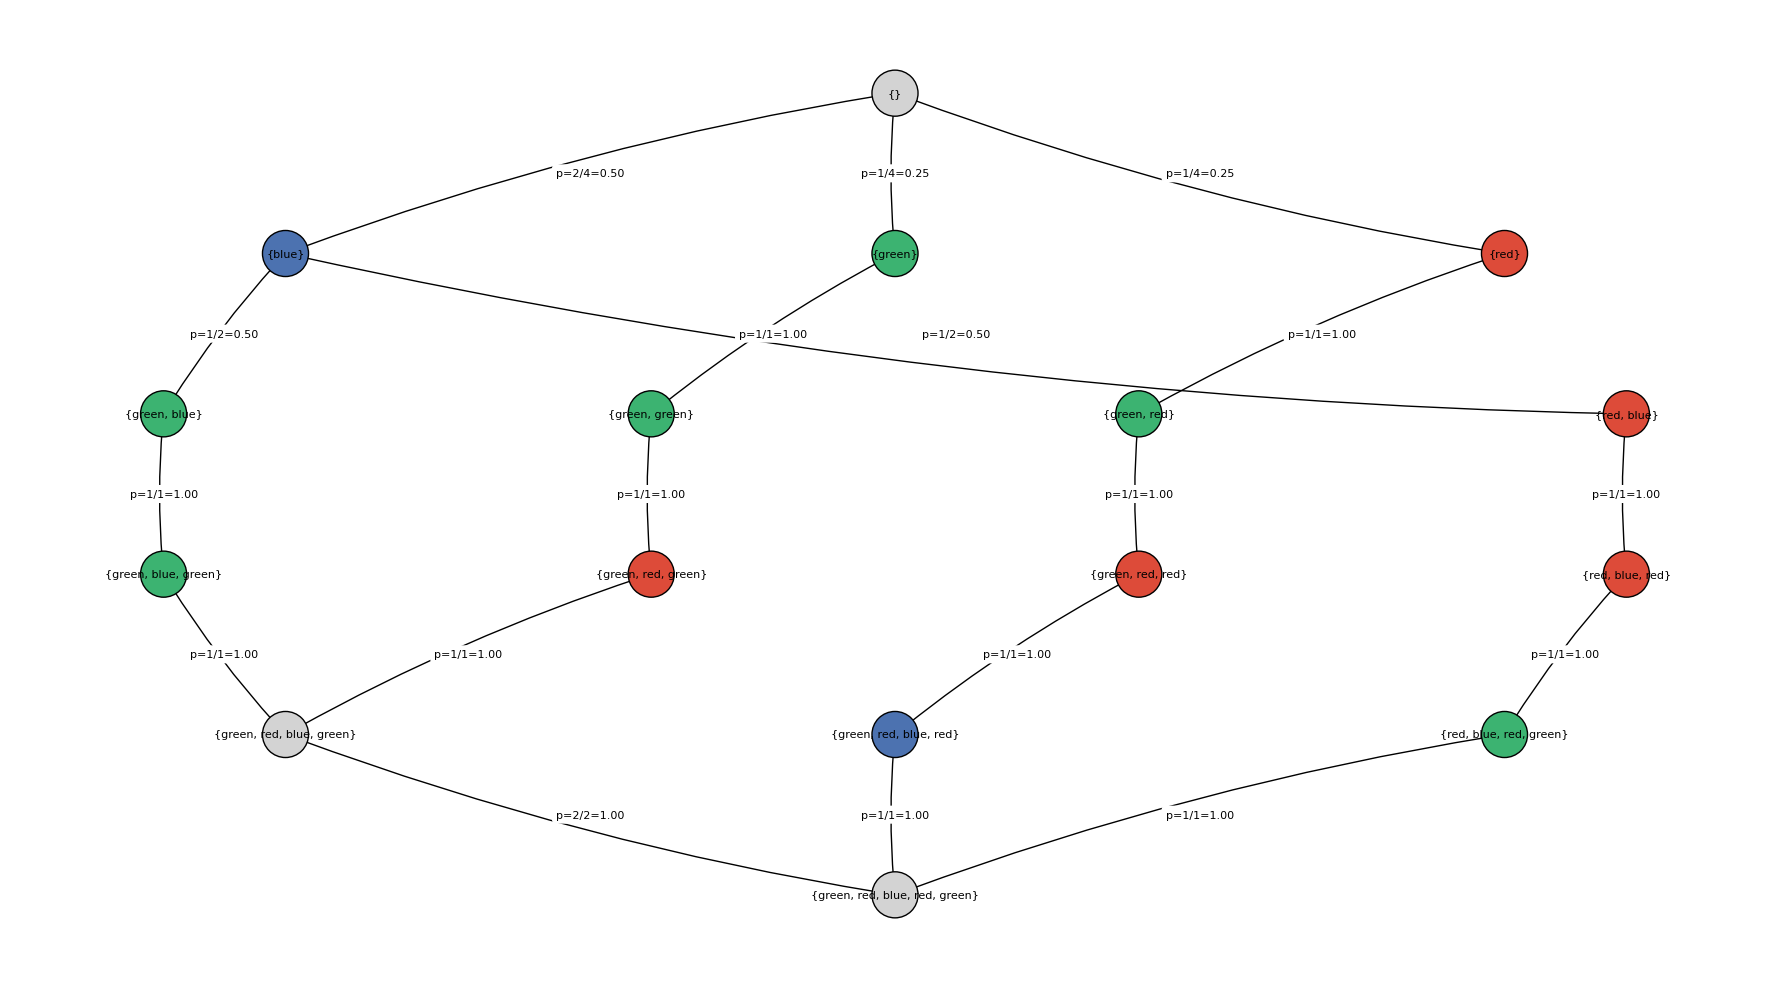

In [25]:
# Jupyter cell: unified state graph across ALL demos (same state = same node),
# include ALL states (no truncation), and label each edge with:
#   n = #unique demonstrations that used transition (s -> s')
#   p = n / (total #unique demonstrations that have ANY outgoing transition from s)
#
# Assumes you already have `steps_df` with columns:
#   demo_id, state (tuple), next_state (tuple)
# Optional: action (str) for display.

import math
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# ----------------------------
# 0) Validate + sort
# ----------------------------
need_cols = {"demo_id", "state", "next_state"}
missing = need_cols - set(steps_df.columns)
if missing:
    raise ValueError(f"steps_df missing columns: {missing}")

sort_cols = [c for c in ["demo_id", "step", "move_end_frame", "move_end_time_s"] if c in steps_df.columns]
steps_sorted = steps_df.sort_values(sort_cols).reset_index(drop=True) if sort_cols else steps_df.copy()

# ----------------------------
# 1) Build unified nodes + edge demo sets
# ----------------------------
G_all = nx.DiGraph()

all_states = set(steps_sorted["state"].tolist()) | set(steps_sorted["next_state"].tolist())
for s in all_states:
    G_all.add_node(s)

edge_demo_ids = defaultdict(set)          # (u,v) -> {demo_id,...}
state_out_demo_ids = defaultdict(set)     # u -> {demo_id,...} for any outgoing transition from u
edge_action_counts = defaultdict(Counter) # (u,v) -> Counter(action) (optional)

has_action = "action" in steps_sorted.columns

for r in steps_sorted.itertuples(index=False):
    u = r.state
    v = r.next_state
    demo = r.demo_id

    # ensure existence
    G_all.add_edge(u, v)

    edge_demo_ids[(u, v)].add(demo)
    state_out_demo_ids[u].add(demo)

    if has_action:
        a = getattr(r, "action")
        if a is not None and str(a).strip() != "":
            edge_action_counts[(u, v)][str(a)] += 1

# ----------------------------
# 2) Attach edge attributes: n and p = n / total_out_demos_from_state
# ----------------------------
for (u, v), demos in edge_demo_ids.items():
    n = len(demos)
    denom = len(state_out_demo_ids.get(u, set()))
    p = (n / denom) if denom > 0 else 0.0

    act_mode = None
    if (u, v) in edge_action_counts and len(edge_action_counts[(u, v)]) > 0:
        act_mode = edge_action_counts[(u, v)].most_common(1)[0][0]

    G_all.edges[u, v]["n_demos"] = n
    G_all.edges[u, v]["p"] = p
    G_all.edges[u, v]["denom_out_demos"] = denom
    G_all.edges[u, v]["action_mode"] = act_mode

print(f"Unified graph nodes (unique states): {G_all.number_of_nodes()}")
print(f"Unified graph edges (unique transitions): {G_all.number_of_edges()}")

# Quick sanity check for root-like states
# (e.g., for () should show denom equal to #demos that include at least one transition from ())
maybe_root = tuple()
if maybe_root in state_out_demo_ids:
    print(f"Outgoing demo count from {maybe_root}: {len(state_out_demo_ids[maybe_root])}")

# ----------------------------
# 3) Layered layout by depth = len(state)
# ----------------------------
def node_label(s):
    if not s:
        return "{}"
    return "{" + ", ".join(map(str, s)) + "}"

layers = defaultdict(list)
for s in G_all.nodes:
    layers[len(s)].append(s)

for d in layers:
    layers[d] = sorted(layers[d], key=lambda t: (len(t), str(t)))

pos = {}
max_depth = max(layers.keys()) if layers else 0
for d in range(max_depth + 1):
    nodes = layers.get(d, [])
    k = len(nodes)
    if k == 0:
        continue
    for i, s in enumerate(nodes):
        x = (i + 1) / (k + 1)
        y = 1.0 - (d / max(1, max_depth))
        pos[s] = (x, y)

# -----------------------
# Draw (node color = color added from its parent transition)
# -----------------------
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# --- recompute edge stats (p) robustly ---
edge_demo_ids = defaultdict(set)
state_out_demo_ids = defaultdict(set)

for r in steps_df.itertuples(index=False):
    edge_demo_ids[(r.state, r.next_state)].add(r.demo_id)
    state_out_demo_ids[r.state].add(r.demo_id)

for (u, v), demos in edge_demo_ids.items():
    n = len(demos)
    denom = len(state_out_demo_ids[u])
    p = n / denom if denom > 0 else 0.0
    G_all.edges[u, v]["n"] = n
    G_all.edges[u, v]["denom"] = denom
    G_all.edges[u, v]["p"] = p

def node_label(s):
    if not s:
        return "{}"
    return "{" + ", ".join(map(str, s)) + "}"

def added_color(prev_state, next_state):
    """
    Multiset difference: correctly handles duplicate colors.
    """
    prev = [str(x).lower() for x in prev_state]
    nxt  = [str(x).lower() for x in next_state]

    delta = Counter(nxt) - Counter(prev)

    if not delta:
        return None

    items = list(delta.elements())
    if len(items) == 1:
        return items[0]

    return max(delta.items(), key=lambda kv: kv[1])[0]


ROOT_STATE = tuple()
color_of = {}

for v in G_all.nodes:

    # Root always gray
    if v == ROOT_STATE:
        color_of[v] = "gray"
        continue

    parents = list(G_all.predecessors(v))

    # Multiple parents → ambiguous origin → gray
    if len(parents) != 1:
        color_of[v] = "gray"
        continue

    # Exactly one parent → compute added color
    parent = parents[0]
    c = added_color(parent, v)

    if c in ["red", "green", "blue"]:
        color_of[v] = c
    else:
        color_of[v] = "gray"


# ---------- Map to actual display colors ----------
def palette(c):
    if c == "blue":
        return "#4C72B0"
    if c == "red":
        return "#DD4B39"
    if c == "green":
        return "#3CB371"
    return "lightgray"

node_colors = [palette(color_of.get(n, "gray")) for n in G_all.nodes]

# --- draw ---
plt.figure(figsize=(18, 10))

nx.draw_networkx_edges(
    G_all, pos,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=14,
    connectionstyle="arc3,rad=0.05"
)

nx.draw_networkx_nodes(
    G_all, pos,
    node_size=1100,
    node_color=node_colors,
    edgecolors="black"
)

nx.draw_networkx_labels(
    G_all, pos,
    labels={s: node_label(s) for s in G_all.nodes},
    font_size=8,
    font_color="black"
)

edge_labels = {}
for (u, v) in G_all.edges:
    n = G_all.edges[u, v]["n"]
    denom = G_all.edges[u, v]["denom"]
    p = G_all.edges[u, v]["p"]
    edge_labels[(u, v)] = f"p={n}/{denom}={p:.2f}"

nx.draw_networkx_edge_labels(
    G_all, pos,
    edge_labels=edge_labels,
    font_size=8,
    font_color="black",
    rotate=False
)

plt.axis("off")
plt.tight_layout()
plt.savefig("proj2_figs/MDP_tree.pdf")
plt.show()